# train_models2

Train the deep models.

## Step 1: Import modules

In [16]:
import os
import sys
import glob
import math
import time
import pickle
import random
import importlib
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zeno_face_tracker_helpers import *
try:
    from ConfigParser import ConfigParser    # If using Python 2.7
except ImportError:
    from configparser import ConfigParser    # If using Python 3.5
config = ConfigParser()
config.read('config.ini')
sys.path.append(os.path.realpath(config.get('zeno_interface', 'repository_path')))
from video_sources import *
from zeno_interface import *
sys.path.append(os.path.realpath(config.get('facial_landmark_tracker', 'repository_path')))
from ibug_face_tracker import *
from zeno_face_tracker import *
print('All modules imported.')

All modules imported.


## Step 2: Further prepare the dataset

In [17]:
# Load all samples
dataset_folder = os.path.realpath('./dataset2')
batch_folders = sorted(glob.glob(os.path.join(dataset_folder, 'batch_*')))
batch_folders = batch_folders[0:6]
all_samples = []
for batch, batch_folder in enumerate(batch_folders):
    combined_samples_path = os.path.join(batch_folder, 'combined_samples.pkl')
    combined_samples = pd.read_pickle(combined_samples_path)
    for idx in range(combined_samples.shape[0]):
        sample = combined_samples.iloc[idx].to_dict()
        sample['batch'] = batch
        sample['frame_number'] = idx
        all_samples.append(sample)
all_samples_path = os.path.join(dataset_folder, 'all_combined_samples.pkl')
pd.DataFrame(all_samples).to_pickle(all_samples_path, protocol=2)
print('All combined samples are saved to: ' + all_samples_path)

All combined samples are saved to: D:\hhj\zeno_face_tracker\dataset2\all_combined_samples.pkl


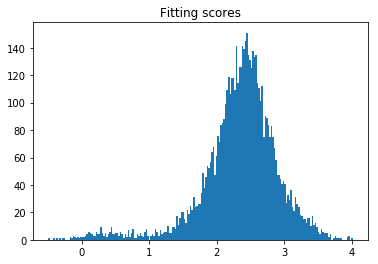

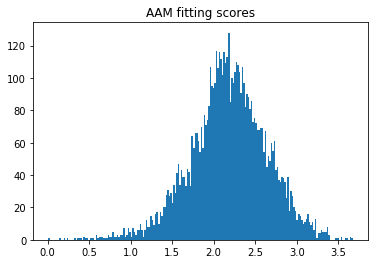

In [18]:
%matplotlib inline

# Observe fitting scores
dataset_folder = os.path.realpath('./dataset2')
all_samples_path = os.path.join(dataset_folder, 'all_combined_samples.pkl')
all_samples = pd.read_pickle(all_samples_path)
fitting_scores = [x.max() for x in all_samples['fitting_scores'].tolist()]
aam_fitting_scores = [x.max() for x in all_samples['aam_fitting_scores'].tolist()]
plt.hist(fitting_scores, bins=200)
plt.title('Fitting scores')
plt.show()
plt.hist(aam_fitting_scores, bins=200)
plt.title('AAM fitting scores')
plt.show()

Mean shape has been saved to: D:\hhj\zeno_face_tracker\dataset2\mean_shape.pts


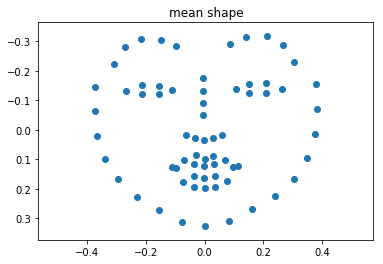

All enhanced samples have been saved to: D:\hhj\zeno_face_tracker\dataset2\all_enhanced_samples.pkl


In [19]:
%matplotlib inline

config.read('config.ini')

# Filter the samples
fitting_score_threshold = np.mean(fitting_scores) - 2 * np.std(fitting_scores)
valid_indices = [idx for idx in range(len(fitting_scores)) if 
                 fitting_scores[idx] > fitting_score_threshold]
valid_samples = all_samples.iloc[valid_indices]

# Calculate mean shape
rescaled_landmarks = []
for landmarks in valid_samples['landmarks']:
    face_size = np.linalg.norm(landmarks.max(axis=0) - landmarks.min(axis=0))
    rescaled_landmarks.append((landmarks - landmarks.mean(axis=0)) / face_size)
mean_shape = np.array(rescaled_landmarks).mean(axis=0)
mean_shape_path = os.path.join(dataset_folder, 'mean_shape.pts')
save_pts(mean_shape_path, mean_shape, 6)
print('Mean shape has been saved to: ' + mean_shape_path)

# Show the mean shape
ax = plt.subplot(1, 1, 1)
plt.scatter(mean_shape[:, 0], mean_shape[:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('mean shape')
plt.show()

# Align everything to the mean shape
enhanced_samples = []
anchors = [int(x) for x in config.get('data_organisation', 'alignment_anchors').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
for idx in range(valid_samples.shape[0]):
    sample = valid_samples.iloc[idx].to_dict()
    transform = compute_rigid_alignment_parameters(sample['landmarks'][anchors], mean_shape[anchors])
    sample['aligned_landmarks'] = apply_rigid_alignment_parameters(sample['landmarks'], *transform)
    sample['aligned_eye_points'] = apply_rigid_alignment_parameters(sample['eye_points'], *transform)
    enhanced_samples.append(sample)
enhanced_samples_path = os.path.join(dataset_folder, 'all_enhanced_samples.pkl')
pd.DataFrame(enhanced_samples).to_pickle(enhanced_samples_path, protocol=2)
print('All enhanced samples have been saved to: ' + enhanced_samples_path)

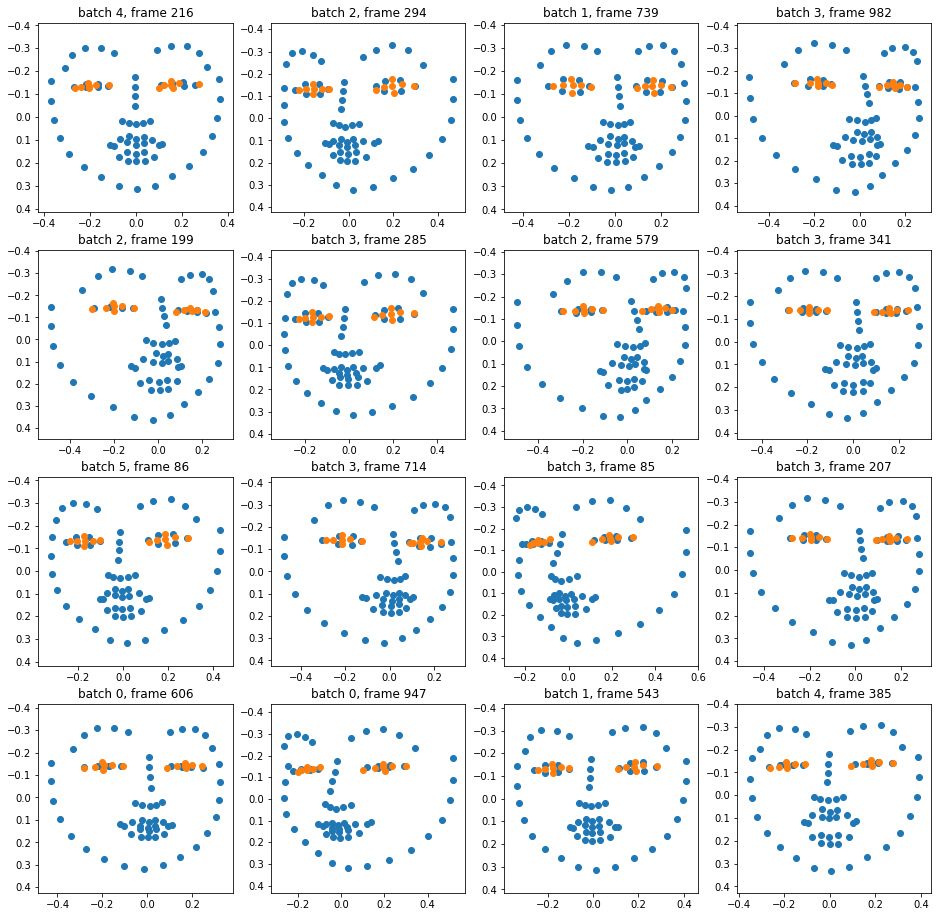

In [20]:
%matplotlib inline

# Randomly show 16 aligned faces
matplotlib.rcParams['figure.figsize'] = [16, 16]
for idx, sample in enumerate(random.sample(enhanced_samples, 16)):
    ax = plt.subplot(4, 4, idx + 1)
    plt.scatter(sample['aligned_landmarks'][:, 0], sample['aligned_landmarks'][:, 1])
    plt.scatter(sample['aligned_eye_points'][:, 0], sample['aligned_eye_points'][:, 1])
    ax.set_aspect('equal', 'datalim')
    ax.invert_yaxis()
    plt.title('batch %d, frame %d' % (sample['batch'], sample['frame_number']))
plt.show()

In [6]:
# Split the data into training set (4/5) and validation set (1/5)
indices = np.random.permutation(len(enhanced_samples))
validation_indices = indices[0: int(len(indices) / 5)]
training_indices = indices[len(validation_indices):]
training_examples = [enhanced_samples[idx] for idx in training_indices]
validation_examples = [enhanced_samples[idx] for idx in validation_indices]
print('We have %d training examples and %d validation examples.' % 
      (len(training_examples), len(validation_examples)))

We have 4721 training examples and 1180 validation examples.


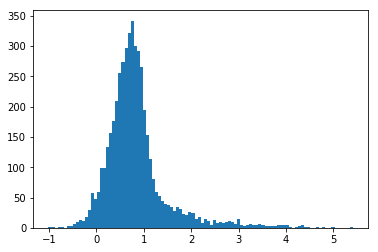

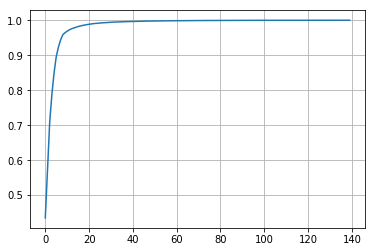

You need 34 dimensions to get 99.5% variation.
This is the MAE validation error: 
[0.01437843 0.03507444 0.04495735 0.02898846 0.08654301 0.0438777
 0.03219446]


In [103]:
%matplotlib inline

def flatten_landmarks(landmarks, eye_points):
    left_iris = eye_points[1:6].mean(axis=0)
    right_iris = eye_points[8:13].mean(axis=0)
    return landmarks.flatten().tolist() + left_iris.tolist() + right_iris.tolist()


# Flatten the examples
actuator_values_tr = []
flattened_landmarks_tr = np.zeros((len(training_examples), 140))
for idx, sample in enumerate(training_examples):
    flattened_landmarks_tr[idx, :] = flatten_landmarks(sample['aligned_landmarks'], sample['aligned_eye_points'])
    actuator_values_tr.append(sample['actuator_values'])
actuator_values_tr = np.array(actuator_values_tr)
actuator_values_val = []
flattened_landmarks_val = np.zeros((len(validation_examples), 140))
for idx, sample in enumerate(validation_examples):
    flattened_landmarks_val[idx, :] = flatten_landmarks(sample['aligned_landmarks'], sample['aligned_eye_points'])
    actuator_values_val.append(sample['actuator_values'])
actuator_values_val = np.array(actuator_values_val)

# Try the min-max appoach
landmark_ranges = np.zeros((2, flattened_landmarks_tr.shape[0]))
for dim in range(flattened_landmarks_tr.shape[1]):
    sorted_dim = sorted(flattened_landmarks_tr[:, dim])
    landmark_ranges[0, dim] = sorted_dim[int(len(sorted_dim) / 25.0)]
    landmark_ranges[1, dim] = sorted_dim[int(len(sorted_dim) / 100.0 * 75.0)]

# Normalise the landmarks
normalised_flattened_landmarks_tr = flattened_landmarks_tr
normalised_flattened_landmarks_val = flattened_landmarks_val
for dim in range(flattened_landmarks_tr.shape[1]):
    normalised_flattened_landmarks_tr[:, dim] = ((flattened_landmarks_tr[:, dim] - landmark_ranges[0, dim]) / 
                                                 (landmark_ranges[1, dim] - landmark_ranges[0, dim]))
    normalised_flattened_landmarks_val[:, dim] = ((flattened_landmarks_val[:, dim] - landmark_ranges[0, dim]) / 
                                                  (landmark_ranges[1, dim] - landmark_ranges[0, dim]))
plt.hist(normalised_flattened_landmarks_tr[:, 96], 100)
plt.show()

# PCA the stuff
input_mean = normalised_flattened_landmarks_tr.mean(axis=0)
input_std = normalised_flattened_landmarks_tr.std(axis=0)
temp = np.divide(normalised_flattened_landmarks_tr - input_mean, input_std)
eigen_values, eigen_vectors = np.linalg.eig(np.cov(temp.T))
cumulative_eigen_values = [np.sum(eigen_values[0: x + 1]) / np.sum(eigen_values) 
                           for x in range(len(eigen_values))]
plt.plot(cumulative_eigen_values)
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.show()
dims995 = len([x for x in cumulative_eigen_values if x <= 0.995]) + 1
print('You need %d dimensions to get 99.5%% variation.' % dims995)
pca_basis = eigen_vectors
flattened_landmarks_tr_pca = np.matmul(temp, pca_basis)

# Try linear regression!
flattened_landmarks_tr_pca_cut = flattened_landmarks_tr_pca[:, 0: dims995]
lr_coefs = np.linalg.lstsq(np.hstack((flattened_landmarks_tr_pca_cut, 
                                      np.ones((flattened_landmarks_tr_pca_cut.shape[0], 1)))), 
                           actuator_values_tr, rcond=None)

# Test the stuff
temp = np.divide(normalised_flattened_landmarks_val - input_mean, input_std)
flattened_landmarks_val_pca = np.matmul(temp, pca_basis)
flattened_landmarks_val_pca_cut = flattened_landmarks_val_pca[:, 0: dims995]
predictions_val = np.matmul(np.hstack((flattened_landmarks_val_pca_cut, 
                                       np.ones((flattened_landmarks_val_pca_cut.shape[0], 1)))), 
                            lr_coefs[0])
errors = (predictions_val - actuator_values_val)
print('This is the MAE validation error: ')
print(np.abs(errors).mean(axis=0))

In [58]:
# Play with MultiPIE
multipie_folder = os.path.realpath('./dataset3')
image_files = glob.glob(os.path.join(multipie_folder, '*.png'))

# Load and fit MultiPIE images
config.read('config.ini')
ert_model_path = '../dlib_and_chehra_stuff/models/new3_68_pts_UAD_1_tr_6_cas_15.dat'
auxiliary_model_path = config.get('facial_landmark_tracker', 'auxiliary_model_path')
tracker = FaceTracker(ert_model_path, auxiliary_model_path)
tracker.face_detection_scale = 2.0
tracker.minimum_face_size = 48
tracker.hard_failure_threshold = -1e6
multipie_landmarks = []
multipie_fitting_scores = []
for image_file in image_files:
    image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2GRAY)
    tracker.reset()
    tracker.track(image)
    if tracker.has_facial_landmarks:
        left_iris = np.mean(tracker.eye_landmarks[1:6], axis=0)
        right_iris = np.mean(tracker.eye_landmarks[7:13], axis=0)
        multipie_fitting_scores.append(tracker.most_recent_fitting_scores)
        multipie_landmarks.append(np.vstack((tracker.facial_landmarks, left_iris, right_iris)))
multipie_fitting_scores = np.array(multipie_fitting_scores).max(axis=1)
print('Done.')

Done.


In [ ]:
# Add CK+ landmarks into the mix
ck_landmarks_folder = os.path.join()

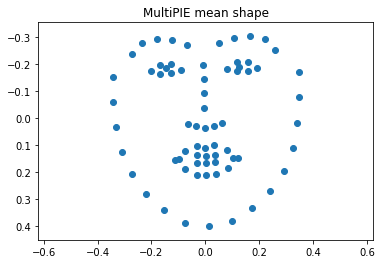

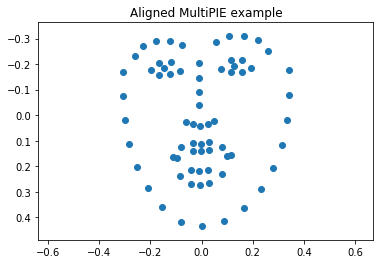

In [104]:
# Calculate mean shape of MultiPIE
temp = []
fitting_score_threshold = multipie_fitting_scores.mean() - 2 * multipie_fitting_scores.std()
for idx, landmarks in enumerate(multipie_landmarks):
    if multipie_fitting_scores[idx] > fitting_score_threshold:
        face_size = np.linalg.norm(landmarks.max(axis=0) - landmarks.min(axis=0))
        temp.append((landmarks - landmarks.mean(axis=0)) / face_size)
multipie_mean_shape = np.array(temp).mean(axis=0)

# Show the mean shape
ax = plt.subplot(1, 1, 1)
plt.scatter(multipie_mean_shape[:, 0], multipie_mean_shape[:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('MultiPIE mean shape')
plt.show()

# Align MultiePIE landmarks to the mean shape
aligned_multipie_landmarks = []
anchors = [int(x) for x in config.get('data_organisation', 'alignment_anchors').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
for idx, landmarks in enumerate(multipie_landmarks):
    if multipie_fitting_scores[idx] > fitting_score_threshold:
        aligned_multipie_landmarks.append(align_landmarks(landmarks, multipie_mean_shape, anchors)[0])

ax = plt.subplot(1, 1, 1)
plt.scatter(aligned_multipie_landmarks[100][:, 0], aligned_multipie_landmarks[100][:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('Aligned MultiPIE example')
plt.show()

# Get the min max range of flattened multipie landmarks
flattened_multipie_landmarks = []
for landmarks in aligned_multipie_landmarks:
    flattened_multipie_landmarks.append(landmarks.flatten())
flattened_multipie_landmarks = np.array(flattened_multipie_landmarks)
multipie_landmark_ranges = np.zeros((2, flattened_multipie_landmarks.shape[1]))
for dim in range(flattened_multipie_landmarks.shape[1]):
    sorted_dim = sorted(flattened_multipie_landmarks[:, dim])
    multipie_landmark_ranges[0, dim] = sorted_dim[int(len(sorted_dim) / 25.0)]
    multipie_landmark_ranges[1, dim] = sorted_dim[int(len(sorted_dim) / 100.0 * 75.0)]

In [108]:
# Test on live video!
webcam = None
zeno_head = None
config.read('config.ini')
try:
    window_title_re = config.get('window_specification', 'title_re')
    window_class_name = config.get('window_specification', 'class_name')
    child_identifier = config.get('window_specification', 'child_identifier')
    window_roi = config.get('window_specification', 'window_roi').replace(
        '\'', '').replace('\"', '').replace('\t', '').replace(' ', '')
    window_roi = tuple([float(x) for x in window_roi.split(',') if len(x) > 0])
    pywinauto = importlib.import_module('pywinauto')
    top_level_window = pywinauto.Desktop(backend='win32').window(title_re=window_title_re,
                                                                 class_name=window_class_name,
                                                                 visible_only=False)
    if len(child_identifier) > 0:
        window_handle = top_level_window[child_identifier].handle
    else:
        window_handle = top_level_window.handle
    webcam = ThreadedWindowCapture(window_handle, 640, 480, 30.0, window_roi)
    zeno_head = ZenoHead('127.0.0.1')
    ert_model_path = '../dlib_and_chehra_stuff/models/new3_68_pts_UAD_1_tr_6_cas_15.dat'
    auxiliary_model_path = config.get('facial_landmark_tracker', 'auxiliary_model_path')
    tracker = FaceTracker(ert_model_path, auxiliary_model_path)
    tracker.minimum_face_size = 128
    while True:
        is_new_frame, frame = webcam.read(0.01)
        if is_new_frame:
            if frame is None:
                break
            else:
                tracker.track(frame)
                tracker.plot_current_result(frame)
                if tracker.has_facial_landmarks:
                    left_iris = np.mean(tracker.eye_landmarks[1:6], axis=0)
                    right_iris = np.mean(tracker.eye_landmarks[7:13], axis=0)
                    aligned_landmarks = align_landmarks(np.vstack((tracker.facial_landmarks, 
                                                                   left_iris, right_iris)), 
                                                        multipie_mean_shape, anchors)[0]
                    aligned_landmarks = aligned_landmarks.flatten()
                    for dim in range(aligned_landmarks.shape[0]):
                        aligned_landmarks[dim] = ((aligned_landmarks[dim] -  multipie_landmark_ranges[0, dim]) / 
                                                  ( multipie_landmark_ranges[1, dim] -  multipie_landmark_ranges[0, dim]))
                    aligned_landmarks = np.divide(aligned_landmarks - input_mean, input_std)
                    feature = np.matmul(aligned_landmarks, pca_basis[:, 0: dims995])
                    motor_positions = np.matmul(feature.tolist() + [1], lr_coefs[0])
                    print(motor_positions)
                cv2.imshow('lalala', frame)
                zeno_head.move(np.clip(motor_positions, 0.0, 1.0), 40)
        key = cv2.waitKey(10)
        if key == ord('q') or key == ord('Q'):
            break
finally:
    cv2.destroyAllWindows()
    if zeno_head is not None:
        zeno_head.reset(400)
        time.sleep(1.0)
        zeno_head.disconnect()
    if webcam is not None:
        webcam.release()

[0.46672828 0.1940404  0.76636995 0.56872599 0.61848033 0.44831759
 0.2727723 ]
[0.47317201 0.20210482 0.77777599 0.58598316 0.58946255 0.45539214
 0.27434339]
[0.47206299 0.19414605 0.79208887 0.58250492 0.60432625 0.45968303
 0.27817875]
[0.47105738 0.18055002 0.80755858 0.57441746 0.58788365 0.47771362
 0.27837603]
[0.47135043 0.17976413 0.79489669 0.58115256 0.57626746 0.48168283
 0.29023635]
[0.47588052 0.19826084 0.80563626 0.55996364 0.54763654 0.44545127
 0.2823313 ]
[0.47377248 0.19987149 0.79365498 0.55494099 0.54689311 0.4225776
 0.284617  ]
[0.47002033 0.20957106 0.78940968 0.56386947 0.57149247 0.41675568
 0.29503227]
[0.47576144 0.23842635 0.79906317 0.57329046 0.56109364 0.38764214
 0.30601271]
[0.46898235 0.23528768 0.79858761 0.56128882 0.58552568 0.39407216
 0.3046878 ]
[0.46806714 0.21976683 0.77129331 0.56471859 0.53118756 0.40454854
 0.28880842]
[0.46730717 0.22391651 0.779247   0.56006554 0.57442049 0.40526486
 0.27282705]
[0.46632831 0.20040731 0.79446385 0.56110

[0.58940031 0.03775505 0.78877213 0.54071339 0.51458993 0.49284865
 0.29102931]
[0.58915841 0.0684759  0.80390224 0.53310167 0.55767774 0.48266817
 0.29304716]
[0.58801839 0.06535782 0.79523648 0.54958146 0.56848442 0.47136804
 0.29140617]
[0.58889502 0.07485173 0.77701956 0.54687153 0.57229065 0.47296311
 0.28656206]
[0.58741424 0.05624375 0.8068598  0.52177033 0.6032287  0.52756809
 0.3018003 ]
[0.58447936 0.03172861 0.82800933 0.48922923 0.70556072 0.57697092
 0.28002661]
[0.58843549 0.00424603 0.81339508 0.46975893 0.70029742 0.60619671
 0.2885206 ]
[ 0.59246348 -0.03852334  0.83058183  0.45096026  0.69010589  0.57090652
  0.27351805]
[0.59932335 0.02005807 0.80800375 0.45274201 0.71038761 0.57101615
 0.26903359]
[ 0.60651665 -0.00649991  0.84525111  0.46227917  0.65715025  0.57162186
  0.28280055]
[0.62076798 0.02693464 0.85815265 0.46120397 0.69020367 0.54128598
 0.28989456]
[0.61844784 0.04156643 0.83359906 0.46430093 0.70021373 0.54888646
 0.28622311]
[0.6179695  0.03909957 0.8

[0.54143293 0.25851455 0.8715666  0.52814302 0.61934239 0.43272581
 0.3319408 ]
[0.54231964 0.25930309 0.87011214 0.52039955 0.61547689 0.43346842
 0.32945929]
[0.54188577 0.25421937 0.84264022 0.52068487 0.62301184 0.43289907
 0.30193103]
[0.54557501 0.18903098 0.86918575 0.52067407 0.6090193  0.47097526
 0.29473456]
[0.54417987 0.22146401 0.8667255  0.52727633 0.61249345 0.4815657
 0.28871744]
[0.54605138 0.21219842 0.87836801 0.53336865 0.62246281 0.4921481
 0.30283316]
[0.54598817 0.19944491 0.87483995 0.52755374 0.61606275 0.4788191
 0.29556462]
[0.54321588 0.18551943 0.87488625 0.53157788 0.64893095 0.49369923
 0.30084299]
[0.5446609  0.18423393 0.88047005 0.52438707 0.63080469 0.47474265
 0.29111519]
[0.5434047  0.19568216 0.87777571 0.51595279 0.63798262 0.48293061
 0.30055611]
[0.54582756 0.20701083 0.85469521 0.53299745 0.6292965  0.45037864
 0.29635573]
[0.54340019 0.21752942 0.8185722  0.54019912 0.55617643 0.43756
 0.28879283]
[0.54232596 0.25415055 0.78858926 0.56439747 0

[0.53079011 0.30195111 0.81474838 0.5503838  0.60319234 0.42979733
 0.38713813]
[0.53160817 0.34612148 0.80794593 0.57736862 0.60741882 0.41500842
 0.37209332]
[0.53023854 0.34860559 0.80074126 0.57978271 0.6146065  0.42186445
 0.35036774]
[0.5289448  0.33690341 0.87819418 0.59852661 0.63808072 0.44071133
 0.3222841 ]
[0.53291252 0.31761863 0.89732574 0.60940587 0.63084402 0.46932592
 0.28509334]
[0.53576482 0.28777307 0.90298696 0.59673454 0.60166126 0.53106347
 0.29426999]
[0.53151511 0.27562521 0.84836608 0.57789908 0.62295799 0.54567935
 0.30501258]
[0.53581642 0.27441034 0.86717634 0.57789335 0.64764624 0.53878982
 0.31842624]
[0.53377706 0.26180299 0.79103919 0.50238277 0.5620851  0.54757591
 0.3117645 ]
[0.54065475 0.2504845  0.73276847 0.46266929 0.51496465 0.54419734
 0.32735387]
[0.53926992 0.25013236 0.70774337 0.4430703  0.48183466 0.58984865
 0.34385604]
[0.54005465 0.21827927 0.63769055 0.42002077 0.51128833 0.5755969
 0.34841999]
[0.55002313 0.19037961 0.69170381 0.41491

[0.48865236 0.33370356 1.04800774 0.3778838  0.87153893 0.54145673
 0.33798096]
[0.48808487 0.33173663 0.96952794 0.3930572  0.80675781 0.52678673
 0.28541045]
[0.48952612 0.33366707 0.87898888 0.44907315 0.65844399 0.47618893
 0.25001665]
[0.49283586 0.32353675 0.87159509 0.43910242 0.65227085 0.49701991
 0.25912818]
[0.49703423 0.31694704 0.80352104 0.5604526  0.56054383 0.43906432
 0.25907087]
[0.50383575 0.30322391 0.82202034 0.5821683  0.59709092 0.45270426
 0.26581069]
[0.50574471 0.28016892 0.81166534 0.57834183 0.58370759 0.4478835
 0.26434384]
[0.50260404 0.28634739 0.79919029 0.57630182 0.57861468 0.45960983
 0.25536383]
[0.50777548 0.2872482  0.79603276 0.60508931 0.54110698 0.43487814
 0.2665194 ]
[0.50571581 0.30257345 0.80339719 0.6051551  0.57332776 0.43074162
 0.26219783]
[0.50569183 0.31460308 0.78803458 0.60452587 0.56282314 0.44368115
 0.2558695 ]
[0.50576085 0.31717853 0.78282311 0.61315108 0.53692033 0.44780768
 0.27473026]
[0.50604501 0.35351606 0.80066344 0.59738

[0.45396816 0.34840996 0.83036417 0.51678967 0.69963632 0.53013406
 0.29571521]
[0.45233302 0.36773633 0.82431401 0.52768258 0.71799707 0.54239202
 0.29251351]
[0.45377054 0.3652558  0.83941402 0.52575321 0.73342732 0.54253631
 0.30792136]
[0.4527056  0.38659608 0.84054023 0.53768535 0.69877434 0.55002949
 0.30986155]
[0.44960318 0.40919445 0.81587733 0.53089175 0.71580176 0.53397112
 0.32238015]
[0.44963875 0.44008181 0.82919622 0.52688738 0.69681406 0.52540859
 0.32636449]
[0.44450601 0.4502268  0.84791418 0.53075961 0.71886409 0.525486
 0.33570737]
[0.44208244 0.48257825 0.81959047 0.51247774 0.75683577 0.49235879
 0.33158394]
[0.44142207 0.51416312 0.82682223 0.52483156 0.69583302 0.46691556
 0.32340687]
[0.43722255 0.48423328 0.80028814 0.50051213 0.73227076 0.50229714
 0.3253573 ]
[0.44253289 0.47126615 0.84580083 0.52029341 0.75479232 0.53216107
 0.31642428]
[0.44564973 0.43977647 0.84012978 0.53021483 0.76016446 0.55469125
 0.34218611]
[0.44286477 0.4107592  0.83480847 0.539199

 0.47624331]
[0.66279657 0.12848251 0.92543304 0.29600609 0.65898528 0.51908206
 0.49408233]
[0.61803445 0.09606839 1.01637736 0.38784813 0.82892963 0.52559339
 0.5086599 ]
[0.66337265 0.12936513 0.83478451 0.30389316 0.70071038 0.49240091
 0.45827399]
[0.63927896 0.09880397 0.87866167 0.37987608 0.67109432 0.54027256
 0.50784227]
[0.62348998 0.03415578 0.90231485 0.32390258 0.92283871 0.61419417
 0.51588857]
[0.63477982 0.03690137 0.88788909 0.38180449 0.88103411 0.55544211
 0.51782634]
[0.62991464 0.06333326 0.99093795 0.33082563 0.80320865 0.5441709
 0.49887308]
[0.62533365 0.03832583 0.92500904 0.34265559 0.92691217 0.48359856
 0.47551567]
[0.65833059 0.13696711 0.86681169 0.29119414 0.72608895 0.47886608
 0.45709173]
[0.66475209 0.06800342 0.85603573 0.29849803 0.74567644 0.47041312
 0.46115145]
[0.67830796 0.09466761 0.84734093 0.35793134 0.64017628 0.52001632
 0.45757038]
[0.65944102 0.08154087 0.91764483 0.2951956  0.71277595 0.51150671
 0.46686081]
[ 0.10425083 -1.08023446  0.

[ 0.51515431 -0.02230016  0.59943421  0.49480915  0.53649523  0.59291066
  0.37006683]
[ 0.50487732 -0.00833517  0.59417972  0.54809301  0.52204026  0.58551304
  0.35373378]
[ 0.51498898 -0.02794841  0.5918026   0.51019703  0.52514614  0.54727127
  0.36539031]
[0.50874789 0.01258406 0.59768735 0.5350196  0.47103931 0.56086873
 0.35985031]
[ 0.51342029 -0.00179729  0.67567697  0.47585458  0.48236785  0.6101139
  0.3711112 ]
[0.51791508 0.05143302 0.55354021 0.47225486 0.49606797 0.52408392
 0.35825795]
[0.50720942 0.05468904 0.6072731  0.51889451 0.50468783 0.63303525
 0.38099192]
[0.51904625 0.0624185  0.67370029 0.50721662 0.54266635 0.65474504
 0.39690104]
[0.52408721 0.03665448 0.64694693 0.54468371 0.70373419 0.66853176
 0.40357937]
[0.52523197 0.03260792 0.73235943 0.33642817 0.7825889  0.74941957
 0.4083383 ]
[0.52014651 0.03014347 0.79325707 0.29188905 0.78376293 0.76302156
 0.40243181]
[0.52209814 0.08780361 0.69012642 0.33105521 0.69160003 0.68857797
 0.39399531]
[0.52134322 0

[0.52591058 0.28130601 0.49737594 0.43819927 0.50404911 0.48064109
 0.3866473 ]
[0.52353561 0.29404149 0.48623747 0.39906239 0.49097923 0.51695169
 0.34696944]
[0.52592495 0.27322378 0.47779402 0.45830492 0.46830488 0.53458595
 0.32259746]
[0.52178554 0.23613222 0.5099507  0.44716841 0.49881439 0.57449679
 0.35085122]
[0.52334248 0.25478142 0.49982501 0.43977586 0.46970782 0.56616002
 0.33718193]
[0.52849622 0.22416972 0.55993385 0.44960939 0.46784718 0.58112233
 0.33581601]
[0.52074546 0.20239884 0.5102766  0.4483528  0.52920898 0.5771776
 0.35262909]
[0.52001633 0.19296489 0.51175377 0.42878141 0.48823152 0.60064179
 0.35097354]
[0.52052102 0.16982577 0.50795165 0.42736793 0.52762881 0.57182418
 0.34586539]
[0.52654606 0.14996284 0.53921409 0.46095157 0.50453798 0.54145103
 0.38116612]
[0.52925106 0.13436189 0.53011409 0.44706508 0.43744071 0.57989753
 0.3484419 ]
[0.53004393 0.128745   0.5762476  0.45914888 0.42068596 0.56585106
 0.37985431]
[0.52519082 0.0956029  0.55844889 0.41901

 0.241334  ]
[0.51983853 0.346096   0.75085629 0.41292982 0.44140278 0.60510565
 0.28950923]
[0.53934725 0.27597999 0.7619339  0.44524584 0.61152638 0.55214979
 0.50566668]
[0.52545831 0.38593195 0.70526102 0.39611037 0.52423026 0.57334352
 0.23434856]
[0.52880692 0.38793945 0.62376329 0.40211948 0.42546885 0.51803505
 0.22443975]
[0.53723304 0.35103247 0.76968777 0.3875292  0.61249511 0.53314401
 0.25747203]
[0.5280444  0.42474727 0.68600109 0.41404273 0.51419843 0.51757707
 0.20467227]
[0.52981761 0.33056559 0.80790136 0.38825354 0.41313696 0.48404702
 0.45255835]
[0.5253104  0.29203275 0.76626488 0.40178298 0.46338681 0.4597689
 0.42360009]
[0.53116132 0.33042909 0.76125792 0.40018472 0.47955971 0.4653181
 0.44405236]
[0.52805609 0.36634944 0.70939173 0.41914554 0.46908884 0.47537547
 0.44971235]
[0.52880739 0.32303972 0.69227727 0.43277039 0.44399771 0.41315264
 0.3920681 ]
[0.5338442  0.34071448 0.79508747 0.41585111 0.4827387  0.42379741
 0.40921627]
[0.53713601 0.342872   0.7445

[0.52552602 0.1314435  0.56392762 0.60226033 0.5224382  0.61543371
 0.38108772]
[0.5314377  0.12992459 0.5663628  0.60732054 0.55090448 0.61141077
 0.3888658 ]
[0.52755594 0.08303216 0.56179857 0.52714478 0.50082084 0.65747325
 0.3981228 ]
[0.52948017 0.08136945 0.55942593 0.55403899 0.51062244 0.65801615
 0.40287447]
[0.52896437 0.07222543 0.63433436 0.55815688 0.53898564 0.67707637
 0.42015738]
[0.51800096 0.05534004 0.46067047 0.57284084 0.56618068 0.62467869
 0.40238051]
[0.52936405 0.11192626 0.51530633 0.53713996 0.58662932 0.62802681
 0.41308614]
[0.47958183 0.09663586 0.44701637 0.5741927  0.44839311 0.76244077
 0.38819294]
[0.51535202 0.03806174 0.5482916  0.53019407 0.55374327 0.68876983
 0.38920385]
[0.52277515 0.03803998 0.54918109 0.52778227 0.51820438 0.65626458
 0.39804921]
[0.51554945 0.03932993 0.57101629 0.52522611 0.51386393 0.64448791
 0.4056769 ]
[0.49188063 0.01950143 0.5332392  0.56798482 0.49460917 0.73750667
 0.38501686]
[ 0.52234168 -0.01585413  0.63141555  0.

[0.4961112  0.17724197 0.8829552  0.51940108 0.63827239 0.85588473
 0.63659737]
[0.5056494  0.15977347 0.88002832 0.50959688 0.64194047 0.89057496
 0.61608495]
[0.51058214 0.14678066 0.88712222 0.50107663 0.63555138 0.87709482
 0.60012239]
[0.50767504 0.13198071 0.91696416 0.50727473 0.62881346 0.91665946
 0.59262569]
[0.50368423 0.13837031 0.90891638 0.49582885 0.64054583 0.89313669
 0.57850999]
[0.50732442 0.13038998 0.90670042 0.48803405 0.65568031 0.91151737
 0.59415896]
[0.51000112 0.14426509 0.91070133 0.48606475 0.61892497 0.89460287
 0.58243564]
[0.50591379 0.12355051 0.91322286 0.48477587 0.63454899 0.90747675
 0.565086  ]
[0.50583057 0.1269945  0.90946026 0.50098031 0.65268405 0.93083051
 0.56245048]
[0.50750493 0.13345461 0.91897237 0.49504727 0.64750921 0.90003545
 0.57595745]
[0.51319237 0.12411044 0.88074879 0.50490947 0.64098422 0.8699016
 0.56661421]
[0.51020066 0.11861756 0.90727643 0.48922297 0.65208529 0.86492577
 0.57769219]
[0.50605554 0.12540543 0.91725017 0.50035

[0.55952877 0.46671276 0.86012947 0.41080358 0.47471497 0.51267992
 0.57421376]
[0.5613724  0.47445012 0.84400629 0.41540816 0.50710404 0.47603691
 0.58387923]
[0.55329034 0.45738861 0.87202993 0.40426209 0.53395538 0.43598475
 0.52790512]
[0.54574268 0.37481966 0.88700143 0.41085008 0.53471882 0.5103396
 0.50491189]
[0.5466172  0.28176947 0.93840868 0.39825584 0.7340661  0.47923356
 0.47769699]
[0.54889202 0.23641899 0.90764982 0.4283225  0.73670085 0.54924134
 0.46869533]
[0.57167269 0.30891397 0.86687827 0.42341774 0.8000864  0.50233978
 0.46304299]
[0.59279794 0.34815397 0.77291484 0.4483915  0.86193368 0.44347006
 0.45812404]
[0.59771845 0.34458579 0.7303075  0.48115727 0.91170502 0.46611873
 0.44561523]
[0.58457439 0.2977776  0.69419505 0.49173539 0.87274367 0.52298482
 0.43912327]
[0.58146809 0.35825167 0.74745702 0.52024299 0.93296231 0.57304089
 0.46210334]
[0.58179378 0.36184341 0.74035937 0.51463707 0.97176516 0.5530776
 0.46094402]
[0.58437904 0.35817387 0.73736466 0.546546

[0.51512583 0.09566858 0.56579689 0.45127511 0.47350278 0.89905474
 0.70021969]
[0.51696    0.09195641 0.5386913  0.49094394 0.49772279 0.85644699
 0.69553843]
[0.51186553 0.12421272 0.51780944 0.49893836 0.51073895 0.86144854
 0.69490883]
[0.51589962 0.11889866 0.53204806 0.48160279 0.50375581 0.86796403
 0.71304764]
[0.50847277 0.12549184 0.48305166 0.46591282 0.48426539 0.78076825
 0.59629772]
[0.51248774 0.0868725  0.52514087 0.50263098 0.5038771  0.84228791
 0.68707734]
[0.51767711 0.07932086 0.51725594 0.46983588 0.51152418 0.80592544
 0.65711536]
[0.51230257 0.10690974 0.53027003 0.53095233 0.53710501 0.83179282
 0.71516332]
[0.51492037 0.11742909 0.52031846 0.51561839 0.52278735 0.84654058
 0.70367886]
[0.5186733  0.101946   0.58685811 0.48158535 0.43799673 0.81944788
 0.68297511]
[0.51858878 0.1148542  0.55183018 0.46901807 0.45485309 0.85808608
 0.6832647 ]
[0.52262078 0.1355003  0.59547812 0.45290033 0.45864293 0.7996622
 0.68198694]
[0.52718701 0.12035737 0.56846523 0.45808

[0.52064837 0.1839444  0.60715459 0.47034648 0.48970624 0.66790015
 0.52527891]
[0.52304708 0.19953122 0.59698356 0.46617274 0.47567719 0.64552784
 0.51071632]
[0.52530448 0.17940138 0.62837831 0.46288458 0.48620736 0.65512673
 0.52613191]
[0.51130025 0.16936701 0.70149883 0.35977011 0.72765698 0.71331286
 0.50780505]
[0.52013071 0.10670202 0.80330087 0.32191916 0.80953676 0.77291695
 0.50647903]
[0.509289   0.12121632 0.77839539 0.35108595 0.80142075 0.75806047
 0.51963701]
[0.43969657 0.07828523 0.61474646 0.50301721 0.63177773 0.69604448
 0.56426941]
[0.70108409 0.06999263 0.32786707 0.53051394 0.88002408 0.82779894
 0.3070431 ]
[0.55292401 1.16829715 0.32722595 0.42934796 0.7805517  0.38598916
 0.60129743]
[0.64589424 0.45706193 0.37012229 0.51860372 0.62143083 0.63459488
 0.44333291]
[0.47445395 0.1784696  0.88086066 0.43878859 0.86047752 0.51323309
 0.40268176]
[0.50116797 0.10916075 0.87026499 0.43507149 0.80568048 0.48832751
 0.32694714]
[0.48842532 0.23426898 0.88454193 0.4315

  0.46424645]
[ 0.49691075 -0.04752128  0.526989    0.52240691  0.41870055  0.72211288
  0.46698081]
[ 0.50027957 -0.01342239  0.51554994  0.56452229  0.40305591  0.70846039
  0.47557545]
[ 0.50121678 -0.02825653  0.52961156  0.54840597  0.40757244  0.71502845
  0.48029548]
[ 0.49674359 -0.05381993  0.52439084  0.53324742  0.42048693  0.72261947
  0.47111345]
[ 0.4934621  -0.03274647  0.50737301  0.54803493  0.40723132  0.70474419
  0.46715574]
[ 0.49093228 -0.0436811   0.51748799  0.52492654  0.42611438  0.72359816
  0.43864803]
[ 0.49562411 -0.03325523  0.50953451  0.56965182  0.47211581  0.72181536
  0.47061906]
[ 0.49868311 -0.02265979  0.49271078  0.56973599  0.44025131  0.71022756
  0.46836197]
[ 0.49534993 -0.02534704  0.48514476  0.56465567  0.4791922   0.71252519
  0.45610675]
[ 4.94050644e-01 -1.72821595e-04  4.85926192e-01  5.71130532e-01
  4.48694212e-01  6.81105569e-01  4.53289358e-01]
[ 0.49389144 -0.01684308  0.47590936  0.56975212  0.44730169  0.69525583
  0.44500744]
[

[0.54240188 0.30075309 0.53498048 0.53730614 0.45226281 0.47486625
 0.39831445]
[0.53444426 0.29236722 0.5183984  0.53463137 0.41923087 0.44288387
 0.38527709]
[0.53402418 0.3064137  0.50819268 0.53273644 0.37777846 0.44662695
 0.37718645]
[0.53668731 0.29018964 0.51542549 0.59416488 0.40798699 0.42742878
 0.39321849]
[0.54967359 0.28361573 0.50032184 0.60035809 0.41174978 0.43132944
 0.39705055]
[0.5552164  0.2718947  0.48607881 0.6045586  0.43811959 0.45373731
 0.41236841]
[0.54661567 0.27691075 0.53576658 0.50859898 0.3791165  0.44651799
 0.40654888]
[0.54536059 0.285937   0.53910608 0.53255959 0.38697497 0.41176059
 0.40114627]
[0.552577   0.29325607 0.53568167 0.53242945 0.41585125 0.42618714
 0.40399991]
[0.56079567 0.3133482  0.51672853 0.54281894 0.41435901 0.43967735
 0.39970132]
[0.55166746 0.30809619 0.53526556 0.52799846 0.38054463 0.42950626
 0.40117663]
[0.55226921 0.28095568 0.54599739 0.52950554 0.38323912 0.42500757
 0.40020717]
[0.55641616 0.27043822 0.53813012 0.5261

[0.58284789 0.54469891 0.42352961 0.50816419 0.41700725 0.40850948
 0.38670938]
[0.58155149 0.50967847 0.47131523 0.49184996 0.38667127 0.41225607
 0.38578119]
[0.59191839 0.5398239  0.48142515 0.53997441 0.46744509 0.37548774
 0.38400356]
[0.58588122 0.51087011 0.44282575 0.53352679 0.46700223 0.40088616
 0.3890291 ]
[0.59394978 0.53189202 0.54079806 0.5492722  0.47727486 0.4443557
 0.39930696]
[0.58603643 0.4915916  0.46802364 0.52687291 0.41947367 0.40648993
 0.39641878]
[0.58654792 0.52504058 0.50543968 0.55333979 0.53158971 0.40549949
 0.40545423]
[0.57668397 0.50649122 0.56952769 0.52840561 0.39251374 0.42917707
 0.38662626]
[0.58834056 0.48888294 0.43354569 0.53069003 0.44615619 0.39705622
 0.37916371]
[0.58364101 0.50106785 0.54229636 0.55379967 0.46812978 0.46604928
 0.40233082]
[0.57477098 0.49680101 0.53509466 0.58239086 0.49054183 0.44308573
 0.39762418]
[0.56675951 0.41387157 0.69714091 0.57843211 0.39023543 0.49948163
 0.41071319]
[0.57513134 0.41810647 0.60362998 0.60146

[0.60295631 0.64903792 0.41433553 0.49924825 0.47676337 0.30970633
 0.35209387]
[0.6131539  0.64619865 0.4628266  0.49539873 0.51013307 0.30987003
 0.34947542]
[0.59914728 0.62099343 0.45156055 0.51235043 0.42777779 0.33258618
 0.34599743]
[0.59520822 0.64742371 0.50502651 0.51414782 0.49016919 0.31508565
 0.35047127]
[0.59367873 0.63081844 0.48133252 0.52299406 0.57073631 0.30096193
 0.36587362]
[0.59447708 0.6158858  0.43973364 0.5220485  0.38531276 0.29324696
 0.33322668]
[0.59051865 0.60031855 0.5446596  0.54035776 0.45596396 0.32524819
 0.35801108]
[0.59578592 0.59594362 0.45229266 0.47971992 0.41333742 0.25378238
 0.31392493]
[0.59787212 0.58646896 0.4702202  0.50415318 0.38279938 0.25286462
 0.32055193]
[0.60628911 0.6104634  0.43918148 0.51501029 0.35256349 0.25959659
 0.32473259]
[0.59791098 0.56443103 0.45285161 0.53534963 0.51110061 0.30218453
 0.34565357]
[0.59872061 0.57194039 0.47738567 0.51986893 0.44884287 0.25747137
 0.32593537]
[0.60328464 0.52830414 0.49849483 0.5521

[0.59039673 0.62368277 0.78183815 0.44002323 0.3952129  0.62036862
 0.65216103]
[0.58758087 0.6305113  0.73853048 0.46931749 0.4346974  0.65346776
 0.60643862]
[0.58658778 0.59174928 0.73917683 0.46667084 0.33317894 0.64501737
 0.58624267]
[0.58573992 0.60377239 0.73025227 0.46364532 0.3061485  0.63398923
 0.5733747 ]
[0.58838953 0.57845237 0.69326535 0.45197023 0.36122969 0.56158439
 0.5232108 ]
[0.59278179 0.62852655 0.66355438 0.44678677 0.40677087 0.52501779
 0.49404388]
[0.5883738  0.58679642 0.68703085 0.43744645 0.44607354 0.5084311
 0.43942609]
[0.58316855 0.62918104 0.64067643 0.45263729 0.35881251 0.47124657
 0.43524612]
[0.58314274 0.57635809 0.67100553 0.41738021 0.41748391 0.51755044
 0.48754248]
[0.59464854 0.55775607 0.81235022 0.44862153 0.51542119 0.60473656
 0.5302577 ]
[0.59725557 0.55066816 0.63255765 0.4678619  0.51607062 0.62295472
 0.61968148]
[0.60169212 0.50541362 0.76668353 0.45394058 0.45553483 0.66505069
 0.69820685]
[0.59778156 0.49343282 0.7060506  0.45219

[0.58611816 0.67722154 0.57016411 0.54111526 0.43396255 0.32405925
 0.36880366]
[0.5800987  0.72678788 0.55578561 0.51177761 0.34190111 0.35575326
 0.36075964]
[0.57232327 0.66642162 0.57518867 0.52988763 0.46362349 0.39865589
 0.38334304]
[0.57497247 0.71703404 0.59695084 0.55187322 0.39916578 0.2844501
 0.39092423]
[0.55145021 0.58111475 0.65745247 0.45283619 0.33977824 0.23614648
 0.38189901]
[0.5579803  0.58275898 0.71181561 0.42509873 0.44306096 0.21997993
 0.3173854 ]
[0.55649019 0.74215759 0.62705972 0.50877776 0.38941515 0.35136709
 0.37019031]
[0.55417384 0.78057695 0.57521506 0.45940149 0.35893676 0.3095233
 0.37293481]
[0.50835218 0.75298334 0.65051791 0.52449338 0.10430032 0.27968639
 0.28634103]
[0.54504502 0.80458514 0.63747889 0.46916249 0.51083232 0.07505521
 0.26996154]
[0.54156734 0.84743545 0.53768068 0.44377624 0.37666553 0.27540912
 0.34358371]
[0.55272666 0.80951588 0.63964519 0.37857283 0.36751214 0.26140441
 0.39406943]
[0.52907646 0.71378598 0.72207906 0.543551

[0.60270858 0.52933369 0.69045709 0.41821611 0.44020911 0.5291891
 0.61998019]
[0.63007972 0.51679196 0.61226594 0.47765746 0.51732452 0.58168229
 0.71739044]
[0.64107981 0.58477642 0.65919426 0.50472875 0.40848192 0.54756152
 0.72090812]
[0.61643522 0.56450738 0.64544251 0.39404365 0.34358558 0.56717769
 0.71566318]
[0.61502745 0.55059284 0.62799156 0.44111086 0.49286497 0.63408745
 0.70908096]
[0.61426904 0.60509043 0.46222171 0.43669741 0.38343761 0.53603822
 0.67954121]
[0.60692124 0.57074683 0.44416067 0.40693484 0.46360208 0.53397847
 0.69455425]
[0.61571661 0.63079006 0.33554538 0.40475878 0.48736618 0.54010715
 0.70851058]
[0.60969666 0.68473014 0.24814585 0.48043466 0.22370397 0.46291986
 0.70569803]
[0.60906934 0.59941067 0.29213328 0.38953881 0.36742252 0.56466318
 0.72606068]
[0.62450859 0.53710861 0.52318452 0.4132218  0.59122947 0.59786043
 0.72953982]
[0.63473164 0.57183899 0.49617713 0.34546872 0.51063132 0.59988822
 0.71206293]
[0.62650776 0.56888155 0.7233112  0.39164

[0.32512279 1.19219145 0.77376974 0.53077869 1.2990248  0.66862344
 0.43724209]
[0.30832143 1.29204309 0.79404431 0.54025246 1.44520187 0.61081065
 0.42244752]
[0.30761186 1.27265934 0.7890273  0.54441218 1.43130099 0.62880549
 0.43659336]
[0.29252849 1.47268668 0.80315349 0.5181831  1.41670763 0.59102792
 0.40634517]
[0.29104564 1.54229314 0.77638267 0.51970888 1.43056713 0.59854568
 0.39946385]
[0.29346778 1.57482982 0.79297748 0.49590411 1.43080628 0.63027012
 0.39884365]
[0.313058   1.51913953 0.79858061 0.53573975 1.44242498 0.58222445
 0.44891747]
[0.33016926 1.46811566 0.77022939 0.5628969  1.35586264 0.57882618
 0.46226681]
[0.33200057 1.48638274 0.79911194 0.55590508 1.37238295 0.56221813
 0.48928817]
[0.3486054  1.39223607 0.81121024 0.54010041 1.38686926 0.60105089
 0.69027826]
[0.37619357 1.35415074 0.81336843 0.54369025 1.24269157 0.52833746
 0.64098976]
[0.35619582 1.39465074 0.80286111 0.53482051 1.26406826 0.51011584
 0.66012875]
[0.37948546 1.3707805  0.82194084 0.5384

[0.56842274 0.42028732 0.8852399  0.61182358 0.8323528  0.40781172
 0.44822637]
[0.57147583 0.43473351 0.87614816 0.63810005 0.81608553 0.4415962
 0.4379414 ]
[0.57312961 0.48517221 0.89623826 0.58083578 0.85841031 0.38167423
 0.43391138]
[0.56420215 0.47350092 0.86421517 0.62271597 0.77443664 0.38703276
 0.43746758]
[0.57181171 0.48748123 0.84850409 0.65342166 0.75401026 0.35940798
 0.44145023]
[0.57518084 0.53839102 0.86558935 0.66591685 0.78403554 0.36151422
 0.43940645]
[0.57637795 0.53458051 0.86897815 0.62896158 0.80620241 0.34421976
 0.42422318]
[0.57533183 0.51246727 0.88061231 0.67626654 0.75988495 0.37491293
 0.4682935 ]
[0.57990861 0.51092895 0.84705477 0.64365893 0.7190536  0.32414113
 0.43258225]
[0.57943012 0.47650256 0.8985624  0.64333109 0.73106463 0.34248443
 0.45166995]
[0.57886002 0.51454671 0.91813893 0.65377482 0.78939151 0.36625108
 0.45214349]
[0.57934862 0.48411466 0.90349889 0.65943417 0.72085174 0.38011316
 0.46983394]
[0.5789711  0.47012882 0.89377908 0.64037

[0.55002732 1.129609   0.93613578 0.54618662 0.50035882 0.42536489
 0.4803715 ]
[0.55007191 1.15511277 1.0058532  0.565763   0.53888125 0.35022662
 0.45479351]
[0.49939358 1.09000554 0.85545558 0.58049048 0.3989752  0.46367375
 0.50528154]
[0.53159553 1.24646436 1.00228391 0.44389504 0.65042148 0.24214034
 0.45956575]
[0.50898505 1.13319215 0.86645997 0.60589932 0.70306263 0.14391699
 0.41881051]
[0.50771421 1.21807869 0.93630581 0.66700865 0.71163732 0.21625337
 0.41203568]
[0.48655844 1.21984098 0.94290118 0.56483718 0.56864529 0.18231633
 0.4222594 ]
[0.48579305 1.02911205 0.90944235 0.55653181 1.03668641 0.60155611
 0.56562829]
[0.4739979  1.00371196 0.85864689 0.53067551 0.88497752 0.52088024
 0.49097944]
[0.47582034 0.92922716 0.80579244 0.55878547 0.75232033 0.36763869
 0.43652355]
[0.49371046 0.86462866 0.85294815 0.5249104  0.64874307 0.45551784
 0.41590631]
[ 0.35976542 -0.02998026  0.69492612  0.75057707  0.76043141  0.40530003
  0.22098136]
[0.43934329 0.81046683 0.89676629

 0.77327036]
[0.48685597 0.41453576 0.87719036 0.55781515 0.6874998  0.47201424
 0.77079309]
[0.46419399 0.3067563  0.82420156 0.54793455 0.75046461 0.52857837
 0.46856651]
[0.4600506  0.3183244  0.80664492 0.54667828 0.77554967 0.52419403
 0.48880965]
[0.4624776  0.29356833 0.82083807 0.53816703 0.76005247 0.56059099
 0.49720573]
[0.46237598 0.38428893 0.8581716  0.55480693 0.76546254 0.53313492
 0.5654784 ]
[0.47342058 0.40122273 0.86639189 0.5617151  0.82339291 0.52573534
 0.58703194]
[0.49616973 0.35519528 0.88164347 0.5480998  0.73722747 0.50198297
 0.52738552]
[0.4894895  0.38016602 0.85916255 0.54339571 0.73289773 0.5071599
 0.53011007]
[0.49372566 0.3927434  0.86562567 0.55882664 0.73613898 0.50239786
 0.4649289 ]
[0.50240092 0.34439887 0.8815705  0.54735935 0.73310464 0.50118807
 0.46726422]
[0.50256416 0.34092809 0.90457805 0.55618023 0.71087251 0.49855419
 0.51922896]
[0.50345137 0.33949775 0.90799192 0.55145688 0.72818966 0.51508369
 0.48475993]
[0.50673631 0.32283967 0.907

[ 0.51805419 -0.03474519  0.59421681  0.43838196  0.56064748  0.64677898
  0.39226233]
[ 0.50745902 -0.03312875  0.71755303  0.51301022  0.56664428  0.70898513
  0.40278749]
[ 0.51182781 -0.10806435  0.70137493  0.51140929  0.57364328  0.72350717
  0.39419199]
[ 0.51092701 -0.04257137  0.56891086  0.46734518  0.54901931  0.61513083
  0.35456369]
[ 0.51131328 -0.00787194  0.61117769  0.44336442  0.50594215  0.6508202
  0.38588098]
[ 0.51892387 -0.04965799  0.61690308  0.44163878  0.58316063  0.65051489
  0.37585502]
[ 0.51749445 -0.04174188  0.60436567  0.4521512   0.53031705  0.64894443
  0.37690489]
[ 0.50842377 -0.03733077  0.62982827  0.47761916  0.58087588  0.70503216
  0.41044517]
[ 0.51170491 -0.03464907  0.62455512  0.42931433  0.53933536  0.665464
  0.3944362 ]
[ 0.50936987 -0.01618051  0.56440706  0.43878574  0.58341118  0.64645571
  0.38373608]
[ 0.50714641 -0.02799565  0.66844637  0.40145405  0.56406066  0.63551208
  0.40155506]
[ 0.50721083 -0.04730084  0.64731573  0.443591

[0.47114922 1.12140798 0.70867436 0.59000349 0.7289667  0.6082733
 0.55664636]
[0.47456263 1.11566246 0.60528896 0.58676032 0.78673792 0.59846598
 0.45665344]
[0.46403603 0.9714109  0.88778467 0.55083345 0.77464512 0.6866645
 0.49153413]
[0.47061006 0.8644849  0.87631237 0.53974259 0.80953498 0.65619691
 0.49428379]
[0.47274094 0.8677156  0.78624464 0.47487373 0.73801934 0.54962768
 0.42654889]
[0.47871689 0.78119207 0.84636269 0.430995   0.74350748 0.46756168
 0.40830104]
[0.49624337 0.60338274 0.88758908 0.42546495 0.7493046  0.50217134
 0.42360732]
[0.49228423 0.64431003 0.93460241 0.4335118  0.75556991 0.52468945
 0.40917275]
[0.5026254  0.61708706 0.87419153 0.41507034 0.75173237 0.45373933
 0.46193675]
[0.51455625 0.56053047 0.84613506 0.46893086 0.63294421 0.33831495
 0.56398069]
[0.48980437 0.47914246 0.84460579 0.4993145  0.58994898 0.49793862
 0.54405333]
[0.46755099 0.40637169 0.80307087 0.49088855 0.56757206 0.59089876
 0.51004261]
[0.47447882 0.43058986 0.79323117 0.479857

[0.27970998 0.74788467 0.60178137 0.42634358 0.97101233 0.4830248
 0.65789989]
[0.26801182 0.67772714 0.45749631 0.33060782 0.78362171 0.21711544
 0.54389045]
[0.23167693 0.70210708 0.60594094 0.40381106 0.4907714  0.46790611
 0.63912153]
[0.26789441 0.88572095 0.52647749 0.46104241 0.23939901 0.26129292
 0.52048233]
[0.28257372 1.08652305 0.53175331 0.51045619 0.61506261 0.25998056
 0.54573648]
[0.42573998 0.95875589 0.67225307 0.63381457 0.92749939 0.50283846
 0.29091799]
[ 0.39826607 -0.07276888  0.94111147  0.55738532  0.69086644  1.03553148
  0.58827762]
[0.36949633 0.07251494 0.9370332  0.56779187 0.77555796 0.68578185
 0.6906496 ]
[0.38496835 0.35944781 0.75782296 0.50103511 0.69285033 0.56672328
 0.66106111]
[0.39393553 0.47907467 0.67022836 0.36288884 0.67872754 0.41663991
 0.62212187]
[0.41132401 0.57385915 0.82895734 0.66116554 0.49528925 0.76818159
 0.72624233]
[0.44517737 0.45627506 0.99090588 0.66013967 0.44287088 0.76770956
 0.62193115]
[0.39148748 0.64811833 0.82149149 

In [9]:
# Prepare training and validation set
def prepare_training_set(samples):
    flattened_landmarks = []
    actuator_values = []
    for sample in samples:
        left_iris = sample['aligned_eye_points'][1:6].mean(axis=0)
        right_iris = sample['aligned_eye_points'][8:13].mean(axis=0)
        flattened_landmarks.append(sample['aligned_landmarks'].flatten().tolist() + 
                                   left_iris.tolist() + right_iris.tolist())
        actuator_values.append(sample['actuator_values'])
    flattened_landmarks = np.array(flattened_landmarks)
    actuator_values = np.array(actuator_values)
    input_mean = flattened_landmarks.mean(axis=0)
    input_std = flattened_landmarks.std(axis=0)
    for idx in range(flattened_landmarks.shape[0]):
        flattened_landmarks[idx] = np.divide(flattened_landmarks[idx] - input_mean, input_std)
    return flattened_landmarks, actuator_values, input_mean, input_std


def prepare_validation_set(samples, input_mean, input_std):
    flattened_landmarks = []
    actuator_values = []
    for sample in samples:
        left_iris = sample['aligned_eye_points'][1:6].mean(axis=0)
        right_iris = sample['aligned_eye_points'][8:13].mean(axis=0)
        flattened_landmarks.append(sample['aligned_landmarks'].flatten().tolist() + 
                                   left_iris.tolist() + right_iris.tolist())
        actuator_values.append(sample['actuator_values'])
    flattened_landmarks = np.array(flattened_landmarks)
    actuator_values = np.array(actuator_values)
    for idx in range(flattened_landmarks.shape[0]):
        flattened_landmarks[idx] = np.divide(flattened_landmarks[idx] - input_mean, input_std)
    return flattened_landmarks, actuator_values


flattened_landmarks_tr, actuator_values_tr, input_mean, input_std = prepare_training_set(training_examples)
flattened_landmarks_val, actuator_values_val = prepare_validation_set(validation_examples, input_mean, input_std)

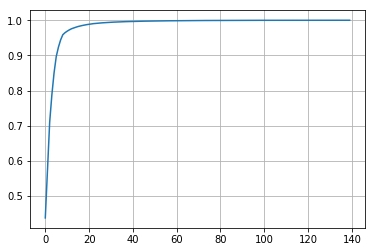

You need 34 dimensions to get 99.5% variation.


In [10]:
%matplotlib inline

# Try to perform PCA on the training set to reduce the number of trainable weights
eigen_values, eigen_vectors = np.linalg.eig(np.cov(flattened_landmarks_tr.T))
cumulative_eigen_values = [np.sum(eigen_values[0: x + 1]) / np.sum(eigen_values) 
                           for x in range(len(eigen_values))]
plt.plot(cumulative_eigen_values)
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.show()
dims995 = len([x for x in cumulative_eigen_values if x <= 0.995]) + 1
print('You need %d dimensions to get 99.5%% variation.' % dims995)
pca_basis = eigen_vectors
flattened_landmarks_tr_pca = np.matmul(flattened_landmarks_tr, pca_basis)
flattened_landmarks_val_pca = np.matmul(flattened_landmarks_val, pca_basis)

In [27]:
# Try linear regression!
dims995=100
flattened_landmarks_tr_pca_cut = flattened_landmarks_tr_pca[:, 0: dims995]
lr_coefs = np.linalg.lstsq(np.hstack((flattened_landmarks_tr_pca_cut, 
                                      np.ones((flattened_landmarks_tr_pca_cut.shape[0], 1)))), 
                           actuator_values_tr, rcond=None)

In [28]:
# Test the stuff
flattened_landmarks_val_pca_cut = flattened_landmarks_val_pca[:, 0: dims995]
predictions_val = np.matmul(np.hstack((flattened_landmarks_val_pca_cut, 
                                       np.ones((flattened_landmarks_val_pca_cut.shape[0], 1)))), 
                            lr_coefs[0])
errors = (predictions_val - actuator_values_val)
print('This is the MAE validation error: ')
print(np.abs(errors).mean(axis=0))

This is the MAE validation error: 
[0.01414915 0.03112931 0.04381014 0.02768138 0.08548945 0.03920616
 0.02587221]


In [30]:
# Test on live video!
webcam = None
zeno_head = None
config.read('config.ini')
try:
    webcam = ThreadedWebcam(0, 640, 480, 30.0)
    zeno_head = ZenoHead('127.0.0.1')
    ert_model_path = '../dlib_and_chehra_stuff/models/new3_68_pts_UAD_1_tr_6_cas_15.dat'
    auxiliary_model_path = config.get('facial_landmark_tracker', 'auxiliary_model_path')
    tracker = FaceTracker(ert_model_path, auxiliary_model_path)     
    while True:
        is_new_frame, frame = webcam.read(0.01)
        if is_new_frame:
            if frame is None:
                break
            else:
                tracker.track(frame)
                tracker.plot_current_result(frame)
                if tracker.has_facial_landmarks:
                    params = compute_rigid_alignment_parameters(tracker.facial_landmarks, 
                                                                shape_model['mean'].astype(np.float32))
                    landmarks = apply_rigid_alignment_parameters(tracker.facial_landmarks, *params)
                    landmarks = np.divide(landmarks - shape_model['mean'], shape_model['std']).flatten()
                    recon = np.matmul(np.matmul(landmarks, shape_model['components'].T[:, 0:30]), 
                                      shape_model['components'][0:30, :])
#                     FaceTracker.plot_facial_landmarks(
#                         frame, np.multiply(recon.reshape(-1, 2), shape_model['std']) + shape_model['mean'] + 100)
                    feature = np.matmul(recon, resampled_pca_basis[0:136, 0: resampled_dims995]) # + magic
                    robo_recon = np.multiply(np.matmul(feature, resampled_pca_basis[:, 0: resampled_dims995].T), 
                                             resampled_input_std) + resampled_input_mean
                    FaceTracker.plot_landmark_connections(frame, robo_recon[0:136].reshape(-1, 2) * 200 + 100)
                    FaceTracker.plot_facial_landmarks(frame, robo_recon[0:136].reshape(-1, 2) * 200 + 100)
                    
                    new_landmarks = np.divide(robo_recon - resampled_input_mean, resampled_input_std)                    
                    feature = np.matmul(new_landmarks, pca_basis[:, 0: dims995]) 
                    
                    motor_positions = np.matmul(feature.tolist() + [1], lr_coefs[0])
                    print(motor_positions.tolist())
                    # Align the face
#                     landmarks, transform = align_landmarks(tracker.facial_landmarks, mean_shape, anchors)
#                     eye_points = (np.matmul(tracker.eye_landmarks, transform[:, 0:2].T) + 
#                                   np.tile(transform[:, 2].T, (sample['eye_points'].shape[0], 1)))
#                     left_iris = eye_points[1:6].mean(axis=0)
#                     right_iris = eye_points[8:13].mean(axis=0)
#                     flattened_landmarks = np.divide(np.array(landmarks.flatten().tolist() + left_iris.tolist() + 
#                                                              right_iris.tolist()) - input_mean, input_std)
#                     feature = np.matmul(flattened_landmarks, pca_basis[:, 0: dims995])
#                     motor_positions = np.matmul(feature.tolist() + [1], coefs[0])
#                     print(motor_positions.tolist())
                    zeno_head.move(np.clip(motor_positions, 0.0, 1.0), 40)
                cv2.imshow('lalala', frame)
        key = cv2.waitKey(10)
        if key == ord('q') or key == ord('Q'):
            break
finally:
    cv2.destroyAllWindows()
    if zeno_head is not None:
        zeno_head.reset(400)
        time.sleep(1.0)
        zeno_head.disconnect()
    if webcam is not None:
        webcam.release()

[0.4308055674801846, 0.2281132537738354, 0.7399397886824381, 0.530650974835371, 0.45850468404860034, 0.2143612779091158, 0.36342669400500227]
[0.43140780406896106, 0.19804191721488268, 0.7606034955602405, 0.521947468480298, 0.4718005448135887, 0.22134295526392556, 0.3523128893740991]
[0.43258135720031177, 0.1852033696169667, 0.7820525005307851, 0.5178941938791358, 0.46118027315505816, 0.2134148259678449, 0.35108317439596143]
[0.4303199079834066, 0.15603452085984176, 0.78281657373356, 0.5180017729275281, 0.4575078532209996, 0.20259001542187144, 0.3493631496362177]
[0.4285786015657326, 0.15622236668189043, 0.7843099603973943, 0.5222963233787717, 0.44452276835997906, 0.19434015505248065, 0.3527605953195485]
[0.4305020938075225, 0.16820484619403486, 0.7617903743471874, 0.5196665739452827, 0.46090806704392173, 0.18187051533370663, 0.3366426409154678]
[0.43031053921835827, 0.15352822538768895, 0.7475984099737075, 0.5257749042916576, 0.4542451049553331, 0.1695741364864775, 0.3365890618744436]

[0.4117872111687797, 0.2127403849777436, 0.6546378786490377, 0.5931196802732179, 0.4238194718953941, 0.360299142694706, 0.17671181473664627]
[0.41222213707971134, 0.19050230827350523, 0.6833596200827927, 0.6031699517385292, 0.41360687287125203, 0.36334690064899006, 0.18956229687052623]
[0.4075839630854697, 0.1828966638555402, 0.6719717755632917, 0.5964514499481239, 0.414592155595638, 0.3707743668714828, 0.18115853739394938]
[0.4070743809740348, 0.1956545794529571, 0.6707974539130124, 0.5811856888204197, 0.4269928835012279, 0.38222171409664984, 0.18600029675521995]
[0.4069335877050279, 0.19189563831122375, 0.6665496779249453, 0.5856292180629382, 0.4251363587764182, 0.3717729397799282, 0.189275457197564]
[0.40726024830430707, 0.192011543338656, 0.6754102554620218, 0.5916242717858474, 0.4130270970325026, 0.3922818581972679, 0.20236570612705218]
[0.4075792707126471, 0.18345500216142047, 0.6897613680207868, 0.601166943593071, 0.41778395035807747, 0.4134435014655402, 0.22159573849691805]
[0.

[0.43858180968075183, 0.16665461175707874, 0.6997627502516344, 0.5987674702081353, 0.44293515400583694, 0.10586701314282376, 0.2438497730477786]
[0.4315564624515706, 0.1344935628186567, 0.7440308129828694, 0.5960076528682748, 0.4376030090775015, 0.0755429608253283, 0.23086585914462499]
[0.4291643706639736, 0.13201744465342152, 0.735220704458184, 0.6007263688440885, 0.4412871540580305, 0.09178314728251585, 0.2347872763726585]
[0.42925721604016015, 0.13635410587309987, 0.7503710530213394, 0.6000472212628589, 0.43247601932280144, 0.07762138005685648, 0.23054582876179813]
[0.42956374747458703, 0.1428603033486493, 0.743778451140474, 0.5848588187481514, 0.4398980577507235, 0.0856304554837557, 0.23886847002230033]
[0.43038391842951285, 0.1423399491924327, 0.7465517391599975, 0.6051300880689074, 0.4455847342112055, 0.07987670542232372, 0.23900350072271104]
[0.43254143184390387, 0.14785361127031094, 0.7429304583002606, 0.5952314519362965, 0.4441183842022933, 0.09062107779255929, 0.2339891753303

[0.43119695282123494, 0.09730191923706821, 0.6792421315248707, 0.5471349596643496, 0.4699701484220517, 0.7280742438984711, 0.5065839109867069]
[0.43256362405595766, 0.10347005120628455, 0.6779069563815624, 0.54901424032888, 0.4705108995054951, 0.7410804343534688, 0.5151872460713516]
[0.43294164523341333, 0.10880505427034198, 0.674349517289653, 0.5522199293410144, 0.47122813565079646, 0.729684766035702, 0.5120901403696271]
[0.43155655001081394, 0.10602054995641952, 0.6972585984032514, 0.5561963717912016, 0.46661605568929687, 0.7516264792232639, 0.5165396995581658]
[0.42980947930123803, 0.10782865052250201, 0.6942406101783345, 0.5538891767255772, 0.46662166431755325, 0.7381588647794877, 0.5016227662365946]
[0.4314396662644454, 0.10405351262445622, 0.6944009854927004, 0.5549494056757747, 0.4659712865013795, 0.7138891520891382, 0.48831013239259297]
[0.4336145727380549, 0.11081265351431485, 0.6889050734085627, 0.5418961547541495, 0.4708553682722837, 0.7387044857614206, 0.4886154375047701]
[

[0.45591991775844487, 0.10581363992171999, 0.6498920655324156, 0.49373396716261503, 0.4654855286298811, 0.5016349052597843, 0.5834999752764185]
[0.4540350217296791, 0.10998929057381507, 0.6474040193331071, 0.48414975336604726, 0.46160431489271014, 0.5344555088542364, 0.5864137308348556]
[0.45573644925325896, 0.10491073863398909, 0.652800745242797, 0.5028791280306953, 0.4602927084623597, 0.5320122593565398, 0.5751297863853463]
[0.4536316088380962, 0.10347765605609649, 0.6397604853099854, 0.4855229377764189, 0.4735684622555099, 0.5058861967575545, 0.548388646703805]
[0.45164439808625906, 0.10321054839465549, 0.6600570424997056, 0.5172982758547426, 0.44726776359043097, 0.522872231235174, 0.5504963255485302]
[0.4491630009005494, 0.11555395297675547, 0.6324637815505543, 0.5027889888449855, 0.46551252482251465, 0.5632944000744685, 0.5337391029296156]
[0.4474523235268667, 0.13383770318599053, 0.6346536479992894, 0.4907023384477295, 0.4648966843430751, 0.60684023702173, 0.5315189815344054]
[0.

[0.4969463065347659, 0.12347808568071988, 1.1293180475536022, 0.5332459466957861, 0.4990200534670471, 0.10261538779611423, 0.42083981080450117]
[0.48279517035704395, 0.09105390104989303, 1.1477781259581166, 0.42365378020890443, 0.502541478970026, 0.18748980508205593, 0.4547287261889133]
[0.47337158693506876, 0.09782158126077911, 1.1255665735609641, 0.4053102407799684, 0.490292388202937, 0.2222744551057183, 0.45258359998522246]
[0.4709294277355801, 0.09900256634877913, 1.069720909213036, 0.40694722696071073, 0.5047320147801027, 0.20823595546733642, 0.4410297836968798]
[0.4727388647622122, 0.1385664493017234, 0.9646758464728951, 0.4233482086285586, 0.5200607990922742, 0.1415512898269548, 0.41685578172006077]
[0.47462464602886273, 0.1727365895518873, 0.868917474692198, 0.45491257272759456, 0.5287880011055512, 0.07489312645485852, 0.3837019405224823]
[0.4718776646827054, 0.1911915444706066, 0.7605442468974346, 0.5041223160629308, 0.5199226152740578, 0.036771738498600826, 0.3720283926859463

[0.49698713395839333, 0.1664866477143891, 1.0815888066867159, 0.7101821463842629, 0.4617802710424666, 0.005989979328199613, 0.41125142291570405]
[0.49678785443584406, 0.16402380108697917, 1.1094155257409481, 0.7183993090145223, 0.4605120316743034, -0.012077732551357079, 0.40983921935641854]
[0.4950934475894562, 0.15850273626326994, 1.0993706443994407, 0.7157223570158502, 0.4708601594880769, -0.008656316262999952, 0.4025578208905186]
[0.49691349205165625, 0.15608877365868423, 1.0825554188580488, 0.6830398012284695, 0.4644227958685273, 0.024274902094729267, 0.4147662062339835]
[0.49950050747638214, 0.13574595431402764, 1.1302527681581052, 0.5072056484111424, 0.49487066884004277, 0.1404049424423725, 0.42622866858435715]
[0.48581418204874705, 0.09448790740297197, 1.200239162333639, 0.4214239450468667, 0.5026392929626571, 0.179004890831107, 0.459594337300546]
[0.4762464543120916, 0.12876719071317372, 1.1323766110130884, 0.40404110556367495, 0.4929059570067305, 0.2269488099033216, 0.46072728

[0.6059994730595585, 0.24564490905826597, 0.7582277317604511, 0.5683713803381295, 0.5730976805152623, 0.08077209234693167, 0.2854007366900778]
[0.6115564435018254, 0.25515550867378173, 0.7853426383710208, 0.5768357198903227, 0.5643390189225592, 0.0797955807734555, 0.2880075210776566]
[0.6122773193157426, 0.2583912572996919, 0.7549449418970557, 0.5760369521442161, 0.579389491093038, 0.07771994290930562, 0.2743460377456882]
[0.6114116341502646, 0.25160216129749025, 0.7575793040974639, 0.5777587207104453, 0.59368917074842, 0.09168280243456944, 0.28529759385558934]
[0.6115681622606526, 0.2534335326015364, 0.7471811933875967, 0.5776309192508351, 0.5899502480597308, 0.08483102472670118, 0.2783890495469516]
[0.6081853537151031, 0.24886195599023986, 0.7620368051829585, 0.5935320894901294, 0.5835727354707834, 0.06806218649550794, 0.27540818660123606]
[0.6101039588369905, 0.25179105314471983, 0.7773247971793829, 0.5780907055699087, 0.5738813348160694, 0.06422375216077952, 0.2777372311978799]
[0.

[0.3510792728162192, 0.6001948703445401, 0.904138810354633, 0.6334126927178283, 0.47008488376720503, 0.007825153641585536, 0.24122830081013902]
[0.330527121103305, 0.5478882271137943, 0.8933864327255009, 0.5861807148127823, 0.31365663428513757, 0.08057925146393652, 0.2490313020277244]
[0.3513360467993162, 0.6576438686735697, 0.906757894812501, 0.5844481997295058, 0.43258208820167166, 0.040504403448114346, 0.2297271386451945]
[0.3536012459625191, 0.5759997311134822, 0.9116106840668039, 0.6246287094057713, 0.4380928184293492, -0.019091897440382477, 0.263075332860692]
[0.33388191705391346, 0.6970326893443805, 0.9879922862187548, 0.6695660949674094, 0.43251215053807923, 0.010657657691212907, 0.16090437836100596]
[0.33752459351960895, 0.6489008314315173, 0.9235263145139639, 0.602166352923463, 0.409862254009956, 0.0502195573581794, 0.23508930383462945]
[0.3476660606711389, 0.6400046107541539, 0.8820178259458452, 0.6054137471021257, 0.4474127933840338, -0.010477388171006907, 0.223346580282145

[0.6018824407844491, 0.3793844086515247, 0.8842327326532426, 0.540301589785286, 0.47668888562107403, 0.20853023976647694, 0.4208829909513844]
[0.609446815618663, 0.3703386198052136, 0.8786643812907613, 0.5219984226771723, 0.4801480101209087, 0.2285276600542107, 0.43037063778192475]
[0.6161369839628286, 0.351782531637136, 0.8835258193869326, 0.5209338211578556, 0.4719508931577165, 0.22314066203794541, 0.4264938466945627]
[0.62286419450131, 0.37756164321445496, 0.8844798945180299, 0.5164094640644904, 0.4980893114527474, 0.2484293358968507, 0.4186358771361712]
[0.6237387094100453, 0.4298863311778078, 0.8905151841260299, 0.521461562973258, 0.47203419920171136, 0.28460501472697064, 0.4355854775871104]
[0.6300231987776038, 0.4082537784880378, 0.9076944172594744, 0.5067370106141393, 0.47573244143741816, 0.2598880399993968, 0.43130803675200746]
[0.6222747082880845, 0.5166018832029202, 0.8539011026021646, 0.5391088309411224, 0.5020492509673664, 0.30381061608391624, 0.41989646682616977]
[0.59334

[0.4573807542159178, 0.3634789953058952, 0.7206863952271592, 0.5578867113176486, 0.514948585646846, 0.07667286222765535, 0.3829801002313948]
[0.43796783494906455, 0.37797060356176077, 0.7009296401530315, 0.5778378316854808, 0.4802654981093522, 0.08114080637371113, 0.3583289670312382]
[0.42225865268639867, 0.3564851303635167, 0.7181218490681391, 0.5879152694795576, 0.4528705571729543, 0.07805853225124865, 0.34684683195069876]
[0.41115630926585245, 0.37903002365463356, 0.7194149514500574, 0.5932059863301786, 0.43675841517730957, 0.0727070739057834, 0.3396642238939876]
[0.39471691801839437, 0.36742128973322474, 0.7341734281610639, 0.6159872846342302, 0.39157207507153285, 0.09144543574363406, 0.33366905581197126]
[0.3874477617798029, 0.36840362976589025, 0.73141859689722, 0.6142147514724517, 0.3735679199532724, 0.09126157370045701, 0.32779099248308696]
[0.3776657291861233, 0.37096221174208405, 0.7525160665294875, 0.6099016276006948, 0.3438466651088683, 0.12590620201095926, 0.33508013094602

[0.507286912761856, 0.2916261070230188, 0.6986557515949817, 0.49210209881783795, 0.5691236926881006, 0.05401357389742101, 0.3470399227901344]
[0.4791018079770065, 0.26193031494373437, 0.7185124414746905, 0.519335697850873, 0.5204661127781167, 0.025065527323009873, 0.33860931488405066]
[0.45958490592585166, 0.2594198650702563, 0.704738580089292, 0.5360942531927668, 0.5037984393081723, 0.015363960160946988, 0.3306962401080663]
[0.4391727038736734, 0.22833271175636344, 0.7272357655084555, 0.5512310885904511, 0.46558411889155943, 0.00926655966967127, 0.3191478706066213]
[0.4266837483493412, 0.24413437874562688, 0.7144573685608526, 0.5635811187199244, 0.4293275092277865, 0.017630097862544825, 0.3231498769533426]
[0.41309910369855846, 0.24480594322349003, 0.7051762822063534, 0.5630000533030133, 0.4047864649189458, 0.012512831533760482, 0.3117262072024727]
[0.4007689571554607, 0.23888911440429644, 0.7338579682660922, 0.5720257298354308, 0.37115730162833915, 0.03873094277622641, 0.311258145602

[0.3941093102947938, 0.055336520643420484, 0.6980426867924344, 0.5377501454636384, 0.3310361069663471, -0.05070865126528251, 0.21981574976000007]
[0.3917987478118157, 0.06199081445073573, 0.7129901638838779, 0.5289379340086784, 0.33772677596190886, -0.05767607559266669, 0.22119260177313949]
[0.3946022291520758, 0.11355568081468187, 0.7027771251677211, 0.5336908163990968, 0.3347138061044873, -0.037551455343039775, 0.23147842363070448]
[0.40082728671706047, 0.14722853862976926, 0.7028882679411897, 0.5466695705778502, 0.37364156484496136, -0.03605839913173131, 0.23587801035944084]
[0.4069372902560162, 0.20572570453127365, 0.7110652652229338, 0.5743873363804666, 0.3733672106620155, 0.004101163219605797, 0.2728599921837387]
[0.40661630119999187, 0.23603200393282187, 0.7166481894081582, 0.5931737042181716, 0.3719408486304542, 0.007795394466132699, 0.2894340096914797]
[0.4079681628849322, 0.25804450275701474, 0.7086826738206509, 0.5839167709357672, 0.3920674006769369, 0.014170412776438768, 0.

[0.4726386602942866, 0.8765887821491336, 1.1706732577702783, 0.5417067768435695, 0.572194578004728, 0.6645729231100674, 0.8671605365328439]
[0.475894762208385, 0.8780048057616641, 1.2141272793553066, 0.5715027533424978, 0.5680122489559694, 0.6418468919973016, 0.9144320181971968]
[0.4712958432974176, 1.0054612779064163, 0.8554949434382262, 0.5713574845130641, 0.5751287721717504, 0.46342446218807704, 0.7399096668566413]
[0.46046028218352275, 0.9702385157152296, 0.8915009595455534, 0.5460185217540005, 0.5530479353636185, 0.5473302027571058, 0.8368773640132094]
[0.4607827809272205, 1.0071379206454223, 0.9932485676821659, 0.53407581709902, 0.5277150983965291, 0.7792076665198944, 0.8839583820185712]
[0.4625298104956948, 1.0710564545673504, 0.840277604995366, 0.5650213109156054, 0.5395496186047906, 0.5951352213792594, 0.7956432753587002]
[0.46435430695043667, 1.1500921841270926, 0.7353218851058647, 0.5399558466319375, 0.5426359040393436, 0.5834306695551355, 0.7255690961903707]
[0.454519636841

[0.46690315736335, 0.815551089763068, 0.8910917184049131, 0.4802443681236495, 0.4416361892569236, 0.6808538720855658, 0.41618748586831605]
[0.4692052063727073, 0.8170329819294362, 0.8931134340423383, 0.4791913277849246, 0.4626226367273919, 0.6872420622072469, 0.42171763161411746]
[0.46746864165424823, 0.7960364261514172, 0.9086917686357885, 0.48811452379898135, 0.45205275911173276, 0.6845696495765752, 0.4196912962015349]
[0.4690791297492045, 0.8048688838561087, 0.9083330830342866, 0.48916981184103264, 0.4583432296107277, 0.684433988309364, 0.42892573530158484]
[0.4653821036043654, 0.8115807857475552, 0.9068584032326518, 0.503398807332476, 0.45961560110414185, 0.6649303860491484, 0.41855724845351644]
[0.46499416408986394, 0.8320940528388598, 0.9006711082733196, 0.49581752009818353, 0.4705250926234559, 0.6911744879576519, 0.42401171255871273]
[0.4642397114518047, 0.8301339401634802, 0.9094015739661729, 0.5095076495684262, 0.46106910406407736, 0.6699437357036733, 0.4258292017406637]
[0.46

[0.4658011379704315, 0.8516177132785048, 0.9312393059922304, 0.48026023717074406, 0.44764744467904166, 0.740677012243367, 0.45437408014703695]
[0.464799677790193, 0.8629512731359135, 0.9089649160971329, 0.47643118086629577, 0.4425901008154652, 0.7328656962967446, 0.4455203155920911]
[0.4649010429537877, 0.8510614549155451, 0.9029368340024289, 0.48163784572242657, 0.43777909511733826, 0.714813356320949, 0.4386022285462276]
[0.46725259452103995, 0.8589584346330146, 0.9032132890259801, 0.4831063274649977, 0.44809436944706743, 0.7019626616336174, 0.43058909558355873]
[0.4675643824166398, 0.8647521803850124, 0.906852966935344, 0.49584694866834034, 0.447139689752514, 0.7072553456378866, 0.43938595771794203]
[0.46525632705083786, 0.863434742951233, 0.9050861471332439, 0.49572110385532203, 0.4488699123021207, 0.6984913402622968, 0.4363521673001389]
[0.46741464486739187, 0.8442935738096152, 0.8985412232484726, 0.4861047214931977, 0.4586700491792148, 0.6853081438090453, 0.43602122424114254]
[0.4

[0.4440825782715441, 0.26609640781726085, 0.536025723782153, 0.5111411830935465, 0.4127398980422075, 0.475758920716956, 0.40916647778233806]
[0.4521701376200918, 0.2542608381675414, 0.6232294187545366, 0.5614547594386429, 0.45329801418705656, 0.34891263379413506, 0.34765772433439757]
[0.45712519255624845, 0.3004563659432312, 0.6274482419783913, 0.538163034731968, 0.44517478841507635, 0.4085976293264675, 0.3937258956309725]
[0.4619407650268214, 0.22292507085885305, 0.7664491681233264, 0.5680105605367939, 0.4952621913510966, 0.21145451757793965, 0.3037493573743518]
[0.46526473524384254, 0.22380289854176455, 0.8107532820593253, 0.5804395624511252, 0.5131975943691329, 0.1490097844931228, 0.29806375825823095]
[0.46879909711015194, 0.28689092540870587, 0.83353678572694, 0.5703168260352722, 0.4911254509552253, 0.19415396242736604, 0.3237042496599154]
[0.4699412628710776, 0.3429177335598582, 0.8358101244240949, 0.5352620207883781, 0.49715114417075434, 0.24849587119186697, 0.3346613679332374]
[

[0.47159659341994203, 0.8708386685240721, 0.9647324076164174, 0.4704451246067034, 0.4382445096897752, 0.7878283985206909, 0.4839626941367584]
[0.4750588209299067, 0.840177066996242, 0.9430624554407374, 0.48132978325155773, 0.43883828707765593, 0.7403842590811419, 0.4971518791400194]
[0.47616308765007787, 0.8517929891565229, 0.9474747908995698, 0.4711861973751888, 0.45225597438214876, 0.7732644231205386, 0.48030375542275394]
[0.4747289154063928, 0.8539916191938955, 0.9310387790819339, 0.47153030862625617, 0.4533532409758373, 0.7670353065936362, 0.4709107503529914]
[0.4773333994702029, 0.8286060186414934, 0.9469557339643204, 0.4509915695818497, 0.4447112189560589, 0.7750055770980019, 0.49148373413075314]
[0.4757163454372957, 0.8113933320419444, 1.0262520876233203, 0.41775193877912253, 0.43553426770336956, 0.8445837655851773, 0.5120074460562634]
[0.4808637815023611, 0.7921149927744584, 1.0393197384251318, 0.43211705049039945, 0.4350279744860018, 0.796205086305105, 0.5023236543039742]
[0.4

[0.48524444813152995, 0.7383235536552994, 0.8071349824652114, 0.4368127735604409, 0.49030745774605833, 0.585913932761456, 0.4178578348047358]
[0.4838152071483814, 0.7538535506883748, 0.795664100579708, 0.44569015545517643, 0.46360973257452376, 0.5731524835796173, 0.38180258391027677]
[0.4839019853446586, 0.7411046661323764, 0.8155183302796614, 0.4518134464668262, 0.4718940330501691, 0.5473683056468978, 0.3921695821529016]
[0.486107369173154, 0.7436054888113999, 0.8069840581074664, 0.4676861838892349, 0.46863911821208915, 0.5689232051635688, 0.40022829563800366]
[0.4856353633079957, 0.7297923422815585, 0.8327820625101147, 0.4690264945101644, 0.4682580374933988, 0.5532776311045638, 0.4133567034213949]
[0.4868150644580483, 0.7426661545237924, 0.8492087394756177, 0.4775352750841564, 0.46604142546865057, 0.5567934788900378, 0.4278657165386978]
[0.48496553835120915, 0.7480654014217274, 0.8489762036507986, 0.48703221339909925, 0.46058667304343465, 0.5878360022146092, 0.44077314523933997]
[0.4

[0.46993726650829615, 0.8396402896567712, 0.9076953650966626, 0.5053732394542247, 0.4484630590308785, 0.6950371424482096, 0.41530120345985666]
[0.4718160747928442, 0.8390993354072935, 0.8944621773561012, 0.4884625351127958, 0.44838295737872264, 0.717409809572998, 0.40902405977499867]
[0.47251400433128016, 0.83579354812374, 0.8963164956163966, 0.49677123380982013, 0.44333398833705395, 0.6712709524443411, 0.41554592434800125]
[0.47411235465972, 0.8369660524721816, 0.8929082422114485, 0.49540321674335297, 0.4438404333563078, 0.6972765294688354, 0.4128227385910401]
[0.47416288624629166, 0.8041361831149529, 0.9006481795406615, 0.4847726536407527, 0.4499992259132729, 0.6751477845065242, 0.42191876853312693]
[0.4756626866137436, 0.7901823528984486, 0.8906420778017934, 0.5026261252741823, 0.4484603568665586, 0.6550708479287014, 0.4193383496205062]
[0.473490575842762, 0.7832925649102793, 0.8879075696577592, 0.4961261044045193, 0.45486154851484467, 0.6526592124035351, 0.4219822176667432]
[0.4755

[0.48197067922704234, 0.7226843482483647, 0.8755861359473627, 0.4836151538759452, 0.45926025018372546, 0.5577823232927166, 0.39582678513535635]
[0.4848922576568219, 0.6912139968449771, 0.87986233333712, 0.47595367000628486, 0.47191841008544927, 0.5352401200464394, 0.3931895426456178]
[0.4811037229993316, 0.6956906000612878, 0.868699964169581, 0.4801579822156771, 0.46348573262471293, 0.5300158526670783, 0.3972138756958651]
[0.4837853757950193, 0.6761734426834198, 0.884588397933538, 0.47381084663238093, 0.4670058903554031, 0.5195075691158092, 0.4109045743033376]
[0.483779424057066, 0.6669870768473616, 0.8815524011564322, 0.4724684334223817, 0.4707142779815716, 0.5153783591567126, 0.41358543619486554]
[0.4834782853916896, 0.6762632200883275, 0.8751908940629922, 0.46756828039143533, 0.47303192270865224, 0.5155419848516892, 0.4099834025643728]
[0.4817801958243033, 0.6735279481651302, 0.8790978002454576, 0.4690530636456217, 0.4629210732372309, 0.5157209613624228, 0.41251605084567244]
[0.4808

[0.48859427158152335, 0.47425311713282386, 0.6690877443292444, 0.5446962418406447, 0.5092303333830522, 0.11984365318008355, 0.33617749788094664]
[0.48571228104515596, 0.46355234758931935, 0.6517781816807762, 0.5341022671891784, 0.5117186631612776, 0.11188358600531184, 0.3320996427723135]
[0.48750696066264054, 0.454560494098948, 0.6806243603019366, 0.546659001675214, 0.5090005232365661, 0.11339064915748087, 0.3386784454079164]
[0.48623980459505634, 0.46184683092308776, 0.6745990919490727, 0.5374025675462704, 0.5093242225100447, 0.11936956669268017, 0.33561274859584156]
[0.4840433713144003, 0.46585046779275197, 0.671759488815936, 0.5730204578012722, 0.4904390421504052, 0.09107318464197106, 0.33868895129372023]
[0.48250868687227, 0.4611252569706367, 0.6721933783197123, 0.561281287276591, 0.4900417758355297, 0.10446750128344279, 0.33506771787807726]
[0.48527369168988005, 0.4559017685613447, 0.6717307900934083, 0.544765996367794, 0.5166398589250578, 0.09922069263382094, 0.32791561533117985]

[0.4740692254384673, 0.37747111647854104, 0.7810781618394156, 0.523988700467329, 0.5055518710691448, 0.17699907683232324, 0.34381537183350036]
[0.4739250517139362, 0.37863048102871005, 0.780548179264853, 0.5272730312945257, 0.5141322793464956, 0.164105267863019, 0.3466295509439029]
[0.47600427923331745, 0.37701135904924715, 0.8012779055553313, 0.508405872328437, 0.5166500493920366, 0.18451279290005623, 0.355831697821277]
[0.47605327842026607, 0.3448736361878353, 0.9369021533698574, 0.4270885361502851, 0.5174035553524486, 0.30570413978102684, 0.39463594065781527]
[0.47271095739077323, 0.3337984148474322, 0.9766957413072108, 0.42336175400089177, 0.4801861680783585, 0.3310856684327018, 0.4044016632145435]
[0.4724068656253658, 0.32415565643431216, 0.9480038148944347, 0.4117150698794328, 0.5162562902261209, 0.2981082297210915, 0.3885180514226618]
[0.4731396995027089, 0.3296955868243535, 0.8942001313787455, 0.4229818865918735, 0.5123580878983854, 0.2789667481288671, 0.38275069679444607]
[0.4

[0.48177890496004405, 0.40293333691699174, 0.7001870540291563, 0.5375362092269192, 0.5258900907021986, 0.1022996957033856, 0.3340577150745913]
[0.47958154191340624, 0.4100384498608956, 0.6797128495641241, 0.558488541829574, 0.5330612713845443, 0.09763385047782747, 0.3263752259856071]
[0.4810148256412721, 0.4113571142911965, 0.6751626971121407, 0.5741620558179377, 0.5085787710100642, 0.09584862040775372, 0.32622431329722124]
[0.4799229335514247, 0.41932431521907004, 0.6626692997181194, 0.5832574471336989, 0.5113478233374469, 0.09336647361632827, 0.32036414531411206]
[0.47857087685157673, 0.40231954825406097, 0.6655827263247123, 0.5520804746933012, 0.5125960944681156, 0.09126382961941032, 0.3218854592044824]
[0.4789788229486497, 0.4112992381514901, 0.6761038162801347, 0.5639675490792323, 0.5152279954104768, 0.09961306888152999, 0.32987643486154444]
[0.4802271177684868, 0.4072562933603882, 0.6621972032418811, 0.5815463251414105, 0.5052570467167847, 0.06985865674250397, 0.32029390531679536

[0.4679025464446592, 0.4587665891437964, 0.4585113966040831, 0.3808023615607835, 0.5596382590706055, 0.20572434411063384, 0.3385160189866284]
[0.46771580657955214, 0.445516124939601, 0.4193872246284218, 0.346062179666244, 0.566215491760323, 0.19299418946300673, 0.32418267854722604]
[0.47245066540917, 0.47994081659676324, 0.4040160110318362, 0.3393439839421989, 0.5629501143279547, 0.19027059772405475, 0.3255157839967524]
[0.4715676226524865, 0.48962956265438556, 0.4050940239530937, 0.3460357871284927, 0.5622890081647185, 0.19153712817821927, 0.3174369594829599]
[0.4719759414677068, 0.4938032896213928, 0.40578337649016105, 0.35637926312051144, 0.5853939862460751, 0.17988147893389145, 0.31126990164780444]
[0.471292096133983, 0.4850548105433609, 0.4010925207374057, 0.36312850813320663, 0.5542737032329469, 0.17980513282196509, 0.32483351965517604]
[0.4693009177405862, 0.4948121405432413, 0.407040048749293, 0.36366632085175077, 0.5584913028834099, 0.20447516021030498, 0.32404050120653594]
[0

[0.4567238177995732, 0.4545092886148339, 0.42342552857316806, 0.3588278219913203, 0.5347532055347826, 0.27443374691117745, 0.3466307330011581]
[0.4568960943379977, 0.4620013992715925, 0.4291302488485772, 0.35883645844116285, 0.526317324403935, 0.2927855067132501, 0.35783745952488727]
[0.45323266760148806, 0.47226177060515845, 0.41524737796631017, 0.3530145533332124, 0.5295496567599577, 0.30846544976700074, 0.3498713895736194]
[0.45619068762395454, 0.4822930314673351, 0.4174351041393397, 0.3550116953167035, 0.5261244227980206, 0.31725701259766115, 0.3563634584453388]
[0.45409701181776607, 0.48437141254632765, 0.43842164013649354, 0.37351463376583505, 0.5226527873068363, 0.314063449113962, 0.35227051172234736]
[0.45362496324639406, 0.46540202429153404, 0.4760787036600321, 0.3612411762254284, 0.5138636703115422, 0.30887658097440274, 0.3487210120997668]
[0.4587029779041567, 0.4551643322554661, 0.5612734877848832, 0.3840602161258595, 0.5157425389661855, 0.3039126852599834, 0.365085474456077

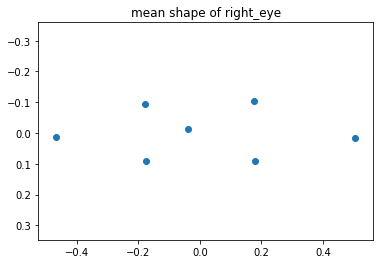

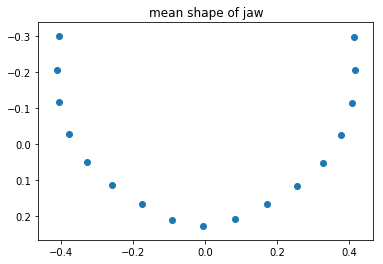

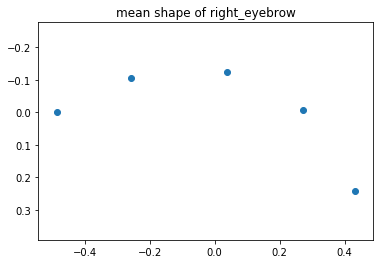

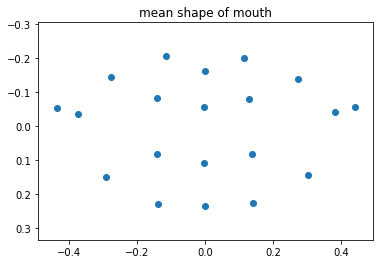

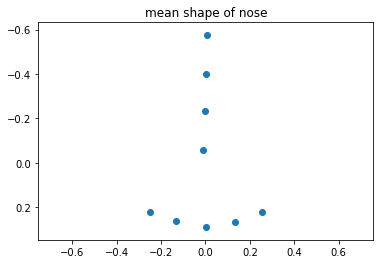

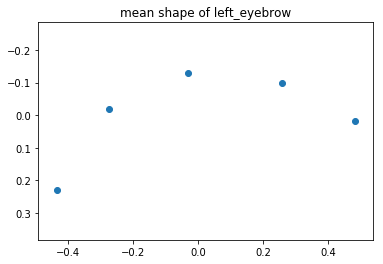

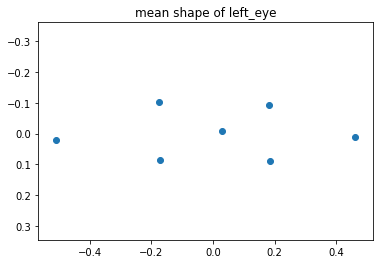

In [15]:
%matplotlib inline

def decompose_landmarks(landmarks, eye_points):
    result = {}
    result['jaw'] = landmarks[0:17]
    result['left_eyebrow'] = landmarks[17:22]
    result['right_eyebrow'] = landmarks[22:27]
    result['nose'] = landmarks[27:36]
    result['left_eye'] = np.vstack((landmarks[36:42], eye_points[1:6].mean(axis=0)))
    result['right_eye'] = np.vstack((landmarks[42:48], eye_points[8:13].mean(axis=0)))
    result['mouth'] = landmarks[48:]
#    result['left_eye_region'] = np.vstack((result['left_eyebrow'], result['left_eye']))
#    result['right_eye_region'] = np.vstack((result['right_eyebrow'], result['right_eye']))
    return result


# Decompose facial components in the training set
all_decomposes_landmarks_tr = {}
for example in training_examples:
    decomposed_landmarks = decompose_landmarks(example['landmarks'], example['eye_points'])
    for key in decomposed_landmarks:
        if key in all_decomposes_landmarks_tr:
            all_decomposes_landmarks_tr[key].append(decomposed_landmarks[key])
        else:
            all_decomposes_landmarks_tr[key] = [decomposed_landmarks[key]]

# Calculate mean shape for each facial components
mean_shapes = {}
for key in all_decomposes_landmarks_tr.keys():
    all_points = []
    for points in all_decomposes_landmarks_tr[key]:
        component_size = np.linalg.norm(points.max(axis=0) - points.min(axis=0))
        all_points.append((points - points.mean(axis=0)) / component_size)
    mean_shapes[key] = np.array(all_points).mean(axis=0)

# Show the mean shapes
for key in mean_shapes:
    ax = plt.subplot(1, 1, 1)
    plt.scatter(mean_shapes[key][:, 0], mean_shapes[key][:, 1])
    ax.set_aspect('equal', 'datalim')
    ax.invert_yaxis()
    plt.title('mean shape of ' + key)
    plt.show()

In [16]:
# Get new training and validation examples
new_flattened_landmarks_tr = {}
for example in training_examples:
    decomposed_landmarks = decompose_landmarks(example['landmarks'], example['eye_points'])
    for key in decomposed_landmarks:
        params = compute_rigid_alignment_parameters(decomposed_landmarks[key], mean_shapes[key])
        landmarks = apply_rigid_alignment_parameters(decomposed_landmarks[key], *params)
        if key in new_flattened_landmarks_tr:
            new_flattened_landmarks_tr[key].append(landmarks.flatten())
        else:
            new_flattened_landmarks_tr[key] = [landmarks.flatten()]
for key in new_flattened_landmarks_tr:
    new_flattened_landmarks_tr[key] = np.array(new_flattened_landmarks_tr[key])
new_flattened_landmarks_tr['eyes'] = np.hstack((new_flattened_landmarks_tr['left_eye'], 
                                                new_flattened_landmarks_tr['right_eye']))
del new_flattened_landmarks_tr['left_eye']
del new_flattened_landmarks_tr['right_eye']
new_flattened_landmarks_tr['eyebrows'] = np.hstack((new_flattened_landmarks_tr['left_eyebrow'], 
                                                new_flattened_landmarks_tr['right_eyebrow']))
del new_flattened_landmarks_tr['left_eyebrow']
del new_flattened_landmarks_tr['right_eyebrow']

new_flattened_landmarks_val = {}
for example in validation_examples:
    decomposed_landmarks = decompose_landmarks(example['landmarks'], example['eye_points'])
    for key in decomposed_landmarks:
        params = compute_rigid_alignment_parameters(decomposed_landmarks[key], mean_shapes[key])
        landmarks = apply_rigid_alignment_parameters(decomposed_landmarks[key], *params)
        if key in new_flattened_landmarks_val:
            new_flattened_landmarks_val[key].append(landmarks.flatten())
        else:
            new_flattened_landmarks_val[key] = [landmarks.flatten()]
for key in new_flattened_landmarks_val:
    new_flattened_landmarks_val[key] = np.array(new_flattened_landmarks_val[key])
new_flattened_landmarks_val['eyes'] = np.hstack((new_flattened_landmarks_val['left_eye'], 
                                                 new_flattened_landmarks_val['right_eye']))
del new_flattened_landmarks_val['left_eye']
del new_flattened_landmarks_val['right_eye']
new_flattened_landmarks_val['eyebrows'] = np.hstack((new_flattened_landmarks_val['left_eyebrow'], 
                                                     new_flattened_landmarks_val['right_eyebrow']))
del new_flattened_landmarks_val['left_eyebrow']
del new_flattened_landmarks_val['right_eyebrow']

In [17]:
# Normalise the dataset
new_flattened_landmarks_tr_mean = {}
new_flattened_landmarks_tr_std = {}
for key in new_flattened_landmarks_tr:
    new_flattened_landmarks_tr_mean[key] = new_flattened_landmarks_tr[key].mean(axis=0)
    new_flattened_landmarks_tr_std[key] = new_flattened_landmarks_tr[key].std(axis=0)    
    for row in range(new_flattened_landmarks_tr[key].shape[0]):
        new_flattened_landmarks_tr[key][row] = np.divide(new_flattened_landmarks_tr[key][row] - 
                                                         new_flattened_landmarks_tr_mean[key], 
                                                         new_flattened_landmarks_tr_std[key])
    for row in range(new_flattened_landmarks_val[key].shape[0]):
        new_flattened_landmarks_val[key][row] = np.divide(new_flattened_landmarks_val[key][row] - 
                                                          new_flattened_landmarks_tr_mean[key], 
                                                          new_flattened_landmarks_tr_std[key])

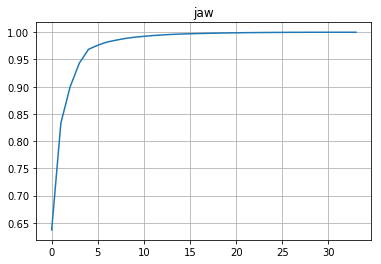

You need 10 dimensions to get 99% variation.


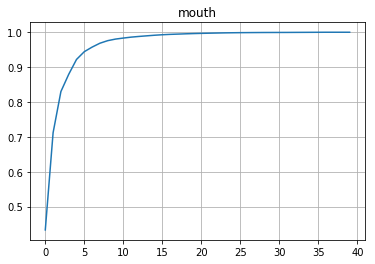

You need 15 dimensions to get 99% variation.


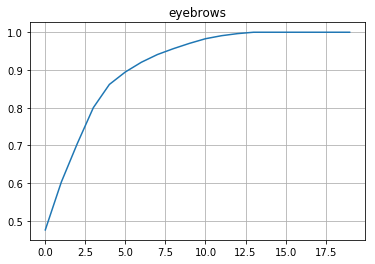

You need 12 dimensions to get 99% variation.


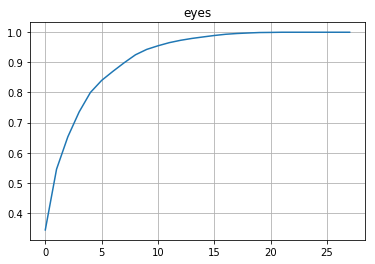

You need 17 dimensions to get 99% variation.


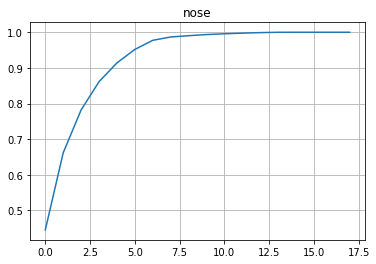

You need 9 dimensions to get 99% variation.


In [18]:
%matplotlib inline

# Try to perform PCA on the training set to reduce the number of trainable weights
new_pca_basis = {}
new_dims99 = {}
new_flattened_landmarks_tr_pca = {}
new_flattened_landmarks_val_pca = {}
for key in new_flattened_landmarks_tr:
    eigen_values, eigen_vectors = np.linalg.eig(np.cov(new_flattened_landmarks_tr[key].T))
    eigen_vectors = np.real(eigen_vectors)
    eigen_values = np.real(eigen_values)
    cumulative_eigen_values = [np.sum(eigen_values[0: x + 1]) / np.sum(eigen_values) 
                               for x in range(len(eigen_values))]
    plt.plot(cumulative_eigen_values)
    plt.grid(b=True, which='major')
    plt.grid(b=True, which='minor')
    plt.title(key)
    plt.show()
    new_dims99[key] = len([x for x in cumulative_eigen_values if x <= 0.99]) + 1
    print('You need %d dimensions to get 99%% variation.' % new_dims99[key])
    new_pca_basis[key] = eigen_vectors
    new_flattened_landmarks_tr_pca[key] = np.matmul(new_flattened_landmarks_tr[key], 
                                                    new_pca_basis[key][:, 0: new_dims99[key]])
    new_flattened_landmarks_val_pca[key] = np.matmul(new_flattened_landmarks_val[key], 
                                                     new_pca_basis[key][:, 0: new_dims99[key]])

In [20]:
# Train multiple regressors
jaw_nose_tr = np.hstack((new_flattened_landmarks_tr_pca['jaw'], new_flattened_landmarks_tr_pca['nose']))
eyebrows_nose_tr = np.hstack((new_flattened_landmarks_tr_pca['eyebrows'], new_flattened_landmarks_tr_pca['nose']))
eyes_nose_tr = np.hstack((new_flattened_landmarks_tr_pca['eyes'], new_flattened_landmarks_tr_pca['nose']))
mouth_nose_tr = np.hstack((new_flattened_landmarks_tr_pca['mouth'], new_flattened_landmarks_tr_pca['nose']))

lr_coef_neck = np.linalg.lstsq(np.hstack((jaw_nose_tr, np.ones((jaw_nose_tr.shape[0], 1)))), 
                               actuator_values_tr[:, 0:2], rcond=None)
lr_coef_eyebrows = np.linalg.lstsq(np.hstack((eyebrows_nose_tr, np.ones((eyebrows_nose_tr.shape[0], 1)))), 
                                   actuator_values_tr[:, 2], rcond=None)
lr_coef_eyes = np.linalg.lstsq(np.hstack((eyes_nose_tr, np.ones((eyes_nose_tr.shape[0], 1)))), 
                               actuator_values_tr[:, 3:5], rcond=None)
lr_coef_mouth = np.linalg.lstsq(np.hstack((mouth_nose_tr, np.ones((mouth_nose_tr.shape[0], 1)))), 
                                actuator_values_tr[:, 5:], rcond=None)

In [21]:
# Test the stuff
jaw_nose_val = np.hstack((new_flattened_landmarks_val_pca['jaw'], new_flattened_landmarks_val_pca['nose']))
eyebrows_nose_val = np.hstack((new_flattened_landmarks_val_pca['eyebrows'], new_flattened_landmarks_val_pca['nose']))
eyes_nose_val = np.hstack((new_flattened_landmarks_val_pca['eyes'], new_flattened_landmarks_val_pca['nose']))
mouth_nose_val = np.hstack((new_flattened_landmarks_val_pca['mouth'], new_flattened_landmarks_val_pca['nose']))

neck_val = np.matmul(np.hstack((jaw_nose_val, np.ones((jaw_nose_val.shape[0], 1)))), lr_coef_neck[0])
errors = (neck_val - actuator_values_val[:, 0:2])
print('This is the MAE validation error for neck joints: ')
print(np.abs(errors).mean(axis=0))

eyebrows_val = np.matmul(np.hstack((eyebrows_nose_val, np.ones((eyebrows_nose_val.shape[0], 1)))), lr_coef_eyebrows[0])
errors = (eyebrows_val - actuator_values_val[:, 2])
print('This is the MAE validation error for eyebrows: ')
print(np.abs(errors).mean(axis=0))

eyes_val = np.matmul(np.hstack((eyes_nose_val, np.ones((eyes_nose_val.shape[0], 1)))), lr_coef_eyes[0])
errors = (eyes_val - actuator_values_val[:, 3:5])
print('This is the MAE validation error for eyes: ')
print(np.abs(errors).mean(axis=0))

mouth_val = np.matmul(np.hstack((mouth_nose_val, np.ones((mouth_nose_val.shape[0], 1)))), lr_coef_mouth[0])
errors = (mouth_val - actuator_values_val[:, 5:])
print('This is the MAE validation error for mouth: ')
print(np.abs(errors).mean(axis=0))

This is the MAE validation error for neck joints: 
[0.02188184 0.15376906]
This is the MAE validation error for eyebrows: 
0.08920107988167413
This is the MAE validation error for eyes: 
[0.04624471 0.10323521]
This is the MAE validation error for mouth: 
[0.06731559 0.04654149]


In [109]:
lr_coef_eyebrows[0].shape

(23,)

In [22]:
# Test on live video!
webcam = None
zeno_head = None
config.read('config.ini')
try:
    webcam = ThreadedWebcam(0, 640, 480, 30.0)
    zeno_head = ZenoHead('127.0.0.1')
    ert_model_path = '../dlib_and_chehra_stuff/models/new3_68_pts_UAD_1_tr_6_cas_15.dat'
    auxiliary_model_path = config.get('facial_landmark_tracker', 'auxiliary_model_path')
    tracker = FaceTracker(ert_model_path, auxiliary_model_path)     
    while True:
        is_new_frame, frame = webcam.read(0.01)
        if is_new_frame:
            if frame is None:
                break
            else:
                tracker.track(frame)
                tracker.plot_current_result(frame)
                if tracker.has_facial_landmarks:
                    # Align the face
                    aligned_landmarks = {}
                    decomposed_landmarks = decompose_landmarks(tracker.facial_landmarks, tracker.eye_landmarks)
                    for key in decomposed_landmarks:
                        params = compute_rigid_alignment_parameters(decomposed_landmarks[key], mean_shapes[key])
                        aligned_landmarks[key] = apply_rigid_alignment_parameters(
                            decomposed_landmarks[key], *params).flatten()
                    aligned_landmarks['eyes'] = np.hstack((aligned_landmarks['left_eye'], 
                                                           aligned_landmarks['right_eye']))
                    del aligned_landmarks['left_eye']
                    del aligned_landmarks['right_eye']
                    aligned_landmarks['eyebrows'] = np.hstack((aligned_landmarks['left_eyebrow'], 
                                                               aligned_landmarks['right_eyebrow']))
                    del aligned_landmarks['left_eyebrow']
                    del aligned_landmarks['right_eyebrow']
                    features = {}
                    for key in aligned_landmarks:                       
                        aligned_landmarks[key] = np.divide(aligned_landmarks[key] - 
                                                           new_flattened_landmarks_tr_mean[key], 
                                                           new_flattened_landmarks_tr_std[key])
                        features[key] = np.matmul(aligned_landmarks[key], 
                                                  new_pca_basis[key][:, 0: new_dims99[key]]).tolist()
                    jaw_nose = features['jaw'] + features['nose']
                    eyebrows_nose = features['eyebrows'] + features['nose']
                    eyes_nose = features['eyes'] + features['nose']
                    mouth_nose = features['mouth'] + features['nose']
                    motor_positions = []
                    motor_positions += np.matmul(jaw_nose + [1], lr_coef_neck[0]).tolist()
                    motor_positions += [np.matmul(eyebrows_nose + [1], lr_coef_eyebrows[0])]
                    motor_positions += np.matmul(eyes_nose + [1], lr_coef_eyes[0]).tolist()
                    motor_positions += np.matmul(mouth_nose + [1], lr_coef_mouth[0]).tolist()
                    print(motor_positions) 
                    zeno_head.move(np.clip(motor_positions, 0.05, 0.95), 40)
                cv2.imshow('lalala', frame)
        key = cv2.waitKey(10)
        if key == ord('q') or key == ord('Q'):
            break
finally:
    cv2.destroyAllWindows()
    if zeno_head is not None:
        zeno_head.reset(400)
        time.sleep(1.0)
        zeno_head.disconnect()
    if webcam is not None:
        webcam.release()

[0.6330296262687676, 0.4343671132309649, 0.5064932689467828, 0.6395346194417411, 0.6351574038948191, 0.1914108538098535, 0.46194980598574087]
[0.6133726798653587, 0.47456159336138154, 0.6643057695033949, 0.5751366073753689, 0.6747208136650523, 0.24256092484206432, 0.3434573327903736]
[0.5617159481123278, 0.4185988937186239, 0.7251914716228769, 0.5360509898925113, 0.6590290574923519, 0.23249437773320808, 0.5779671160781199]
[0.5931815215677856, 0.4387434201812985, 0.7412201974266458, 0.5354538841494427, 0.6962046066500421, 0.2283213722109606, 0.5508744679439231]
[0.590731975007296, 0.46695779521453606, 0.7580449392951881, 0.5608355711528464, 0.6601207231096368, 0.2198376486864292, 0.5195531229224285]
[0.5902543789063024, 0.5022375284890475, 0.6871520132601904, 0.593990534078437, 0.6650867119960726, 0.1678041914399958, 0.4324318279708314]
[0.6019129913476889, 0.47740024376867435, 0.7435482467318943, 0.5760532048083784, 0.6596039824924685, 0.18984022533885986, 0.46751487307221423]
[0.5865

[0.5589903872411776, 0.4504460969248653, 0.7464950814131157, 0.8148458608726272, 0.2070124206987245, -0.12437373436928378, 0.22420951724765192]
[0.5581393095797506, 0.45918751982065986, 0.7846807498068747, 0.8055937068156842, 0.24119728224908504, -0.14283448585728564, 0.22180708458342108]
[0.5537846548389918, 0.4579345426473002, 0.7341990548470388, 0.8233429118143099, 0.2305588021137135, -0.1372831085325309, 0.22735032834323454]
[0.5432267605332785, 0.464379983213353, 0.7389185577737748, 0.8577426139946273, 0.2334965835023105, -0.13382324839764137, 0.23187143976199476]
[0.5423397562365879, 0.4702708871113685, 0.7413846005930316, 0.8290800959025344, 0.2577726926445623, -0.14874328641902568, 0.2253359329951124]
[0.5492320796463523, 0.47769940642828934, 0.7354698127943716, 0.8255354203256882, 0.2492501915548842, -0.14995073439110063, 0.2108033092923759]
[0.5426570562577974, 0.4799129619463933, 0.7619617249802404, 0.8332850698895278, 0.27558093242399173, -0.14087302248385314, 0.22618278984

[0.5237213896988842, 0.2695487253214406, 0.719581069175347, 0.8547480787732489, 0.9197576883752248, 0.10303646333621796, 0.26767457107450365]
[0.5238125569498856, 0.26726760357551615, 0.6903904123303646, 0.8811652582332765, 0.8868498459554337, 0.09305805389794725, 0.2747715579597673]
[0.5237595649648179, 0.29253702097643325, 0.7388434663342042, 0.8350513143278775, 0.8817876964288356, 0.129712675245294, 0.27399309848527964]
[0.5294412773595744, 0.2799830425175099, 0.7058969753714085, 0.8495727844516516, 0.8622985675621451, 0.1225401561762709, 0.280205963149795]
[0.5350975307298302, 0.34494414054557604, 0.7312665365096395, 0.8437033895162871, 0.870331036958404, 0.08132504983092859, 0.26370943801370544]
[0.5331619108948696, 0.31062281484180443, 0.6883384223249587, 0.8322425941043554, 0.8679355485063902, 0.09205313973806417, 0.2868137180355571]
[0.5435556099328108, 0.3362646703700666, 0.7144807380108049, 0.8681248843604743, 0.8703431942119282, 0.08103026390262957, 0.3021245413924534]
[0.53

[0.5463122811908352, 0.6026559747423657, 0.7968073972870174, 0.7902550892817313, 0.19195307155097435, -0.15984545010042084, 0.24130340803842826]
[0.5545041440066799, 0.5549280715202288, 0.8093869660366046, 0.8452349853176473, 0.21716479025720414, -0.1729556060100269, 0.252696137669341]
[0.5591441305498902, 0.5381271384682906, 0.8082299300403512, 0.8957589011491531, 0.21434122246823045, -0.16799620782024338, 0.2533344733690459]
[0.5530186698860693, 0.549150771956303, 0.8131608360152323, 0.9332296732241164, 0.22583184854766664, -0.1728073465366844, 0.23458475064989903]
[0.5517593314511836, 0.6135228551883678, 0.8014499156061735, 1.0347097162451888, 0.21775056139897048, -0.19412775242390523, 0.2504974988497022]
[0.5458189641539963, 0.606479731019568, 0.7917587565800859, 1.0701699465036345, 0.18728255450117798, -0.1822448980747895, 0.23455963054953927]
[0.5493104544457375, 0.6144616907379786, 0.8072449851138106, 1.0530888255704156, 0.17515324684062378, -0.18599363248662815, 0.2341828493449

[0.540359010794371, 0.5386167093158287, 0.8385193829672735, 0.5138150784417604, 0.21348765691103233, -0.1489554858256723, 0.24507797282249127]
[0.5483528536096312, 0.527256994125248, 0.8359987603339235, 0.6246591244458656, 0.20110782038460645, -0.1571212500654917, 0.24261246511649187]
[0.5455693662960214, 0.5259732389543901, 0.7544749451674854, 0.7275782472887898, 0.25816021890520086, -0.16743413240868665, 0.2414723328848763]
[0.5470013636140852, 0.5232242435278286, 0.790552734388782, 0.794749459531249, 0.24202631903555666, -0.1606549268917814, 0.24743124022920154]
[0.547631242596082, 0.5281988286413493, 0.7644250780467751, 0.8219614559075021, 0.2830260259085935, -0.16953967430013872, 0.24483792410412675]
[0.5534050645226788, 0.5027650304106382, 0.7795052251393887, 0.8380168284836793, 0.2632086049197467, -0.15132542734593568, 0.25491933834187486]
[0.5469578717162699, 0.5278298035168263, 0.7903292726637194, 0.8213323101053378, 0.23069228111216689, -0.17364071019519278, 0.252511181567602

[0.5738264325557692, 0.5053618595054893, 0.8018864151979317, 0.782441439619149, 0.25516238989188245, -0.1618108864953668, 0.25895842306761796]
[0.5721156920012594, 0.5018675515341491, 0.8228530424158937, 0.7899885855909168, 0.2477422466553703, -0.13551929342708835, 0.24638743302857813]
[0.5699521317081007, 0.5137287755207447, 0.7931478873331623, 0.8124695622932216, 0.2604823433585642, -0.14617766973416613, 0.2440043067097296]
[0.5690545988565598, 0.5127425086982261, 0.7773350883074523, 0.7796408763411911, 0.195236969320848, -0.1572308553291456, 0.2440377657730265]
[0.5713208624015105, 0.5029021961027327, 0.8210542843337977, 0.7779937426353142, 0.17762218493069687, -0.16126314625212812, 0.2592580590489135]
[0.5738110699426389, 0.48229575930999885, 0.8218422023167542, 0.8007033433475823, 0.2232404769845024, -0.15614556390818124, 0.25646611588180174]
[0.5679229794652578, 0.5336953993290625, 0.8111926789326901, 0.8061054697780411, 0.22819065320953275, -0.14886713501641546, 0.25401390291452

[0.5908563373754097, 0.35437459333557025, 0.7871779182335298, 0.6829742217068104, 0.8207657239705671, 0.29492670157022627, 0.2586916068310149]
[0.5951351823337458, 0.3668125773186215, 0.7306442251466752, 0.680285644493632, 0.8138996642203367, 0.27218317158115213, 0.26209454724517656]
[0.5982131176863754, 0.37938511075686643, 0.7716384827196101, 0.6658947490510678, 0.8297928444851534, 0.1394791740669104, 0.2586127062720929]
[0.5983635471300726, 0.45526745293352006, 0.7527254916648535, 0.6979178049893959, 0.8444875225504763, -0.045207897949568365, 0.2613309170965048]
[0.5997320264070527, 0.4732762300381251, 0.7724244665590458, 0.6994594174029698, 0.8435991442422517, -0.046031345271904445, 0.2541228501908085]
[0.5996598437926691, 0.4626610418280176, 0.7692999847422011, 0.700118608400087, 0.8572299867233404, -0.07160063963488272, 0.2504588433743706]
[0.5939744795508721, 0.4724190087355704, 0.7476564128451373, 0.7062245208359438, 0.8591176539024276, -0.08025792508968987, 0.240648736374576]


[0.562625019940111, 0.42170004455093424, 0.8396956795189583, 0.7526098369332507, 0.1931170164358716, 0.3970973066582403, 0.498363285580541]
[0.5724453330060689, 0.39550337974830263, 0.8322475533067976, 0.7669408252031553, 0.1601615741272946, 0.3880821314944298, 0.5032226939073546]
[0.5704487111553742, 0.40028154671349236, 0.8604625747016026, 0.7532751965256923, 0.21549086724361477, 0.4008462357191591, 0.47838640195641585]
[0.5666464619178262, 0.3764023275832673, 0.8220834168764113, 0.746977437144861, 0.19509106769311035, 0.38694429002502106, 0.47737859101332075]
[0.5768812116377549, 0.3745683729526039, 0.8178894673844336, 0.7561995575593103, 0.1945914181918021, 0.37885619239458096, 0.4715467105325908]
[0.574002020361353, 0.3695769879419263, 0.8169772678981724, 0.731946053152253, 0.19252309713308496, 0.38639057261195775, 0.46007320249853223]
[0.5778262015277124, 0.40296885502464896, 0.8381670968441618, 0.7607294782386372, 0.20683659754873251, 0.3514265973825097, 0.43919810345723864]
[0.

[0.5882087827536251, 0.43196132595486125, 0.7700059927553271, 0.7464420762241962, 0.2037388328877101, -0.10742826356709179, 0.22959926088930283]
[0.5853965125918329, 0.4264851118928935, 0.7751005291162922, 0.7477723245830874, 0.1874627375336511, -0.11650893541008456, 0.21399681154446626]
[0.5844000080141611, 0.431351951608796, 0.7568427491585711, 0.7228064858889423, 0.15933907978698286, -0.1027481887989794, 0.2310027768550561]
[0.5819611881477771, 0.4449127928096123, 0.7706753672827088, 0.7337318688423915, 0.19678239226996247, -0.10184024610548525, 0.23055276861531904]
[0.5756848962960354, 0.44293469405985597, 0.7753840829183797, 0.7812919672219019, 0.21682039813665616, -0.07847401150718403, 0.2472737295950987]
[0.5734572089842476, 0.435403125101444, 0.7862812539699574, 0.7295118290382306, 0.201508639875017, -0.115336855775791, 0.2362442125781436]
[0.5573823381480377, 0.4598801491858568, 0.7655270658571306, 0.7661722900133441, 0.23572322719461242, -0.0920663763880828, 0.248853561571295

[0.3245683119251481, 0.47477607485313816, 0.773240820415491, 0.7382188447518795, 0.900922117214344, 0.008575257882401155, 0.27418544998880773]
[0.3328989243047562, 0.4227379982337617, 0.7151346507160784, 0.817773902958058, 0.7119246818163246, -0.03677309176610499, 0.2688106277594277]
[0.3299675159438804, 0.4378171864855092, 0.7018421191132463, 0.8840564674157627, 0.4695341636044664, -0.0443001108705845, 0.2723889720295275]
[0.336714633786394, 0.43122422669284816, 0.7076414946296541, 0.8723238883070972, 0.3212100547647757, -0.03202276029694695, 0.2856707915720097]
[0.33742617647143436, 0.4228659544151281, 0.6972333566845668, 0.9073640861978416, 0.35468885329234096, -0.02475398052299771, 0.2700019518474322]
[0.33469313043982857, 0.4175493509056898, 0.7077897222090369, 0.9452505492537346, 0.3565189547234338, -0.045247595236696636, 0.2814129118996045]
[0.33518660437669323, 0.42780706925987033, 0.6825765507941328, 0.9383548626577742, 0.3244764338417026, -0.025578823579465948, 0.268465246195

[0.5464517510500133, 0.4746020314662359, 0.8652955333165651, 0.41294438426703645, 0.5485723642401366, -0.07637254427670415, 0.2229965056103993]
[0.5492412608017112, 0.4242996795809739, 0.7764959387103322, 0.5409337100136878, 0.17940891739013703, -0.10150374227570302, 0.225342673796591]
[0.5456030954952014, 0.44256863408232, 0.7593237886785863, 0.7091849063034048, 0.26243043045585546, -0.11721507161155009, 0.22036190447798798]
[0.5497644204222071, 0.44106274331552253, 0.7056911643399474, 0.827087147484591, 0.26118024208927937, -0.1123461323760766, 0.2396776857712361]
[0.5502981165690937, 0.45113925803512955, 0.7097324074814693, 0.9327000303755358, 0.2732247375921184, -0.12536236885948793, 0.23807487639151337]
[0.5488069291013582, 0.4454696963666972, 0.6965508629874017, 0.9720785292815086, 0.2830823086218398, -0.13709292785352367, 0.24211900132558056]
[0.5486700264412666, 0.49384795850605884, 0.715569599383274, 0.9465760588915515, 0.27037770033216857, -0.1454894441630209, 0.2217419182435

[0.5317480143333733, 0.5899043825907722, 0.6502469475005331, 1.0732600126666836, 0.2188008701943382, -0.06889814709857722, 0.2502100113710874]
[0.5330822290928567, 0.6122213903259744, 0.6506781293647264, 1.0801568000092665, 0.20585957130349553, -0.06272386072858682, 0.24763856308867]
[0.5411865287216007, 0.5708885120345626, 0.6291048860819556, 1.0403458874037375, 0.20178164300492546, -0.08474022474001763, 0.24150166300205128]
[0.5319557715191958, 0.5791912599319716, 0.6428165095028603, 1.115285984716536, 0.21032812135349943, -0.08964871109579386, 0.23772701522435236]
[0.5340063100554057, 0.5625928904288606, 0.6457052180964331, 1.0931014749656789, 0.19619383679593927, -0.07108483475258665, 0.25709808970317305]
[0.5323499140304307, 0.5828506001957531, 0.6442672111979914, 1.086591671039058, 0.1583925549062024, -0.070549099239128, 0.23761691563629483]
[0.5399998029950122, 0.5562100851775916, 0.6723328196542115, 0.9864842658983071, 0.18782461675331324, -0.08746584740192365, 0.23449983767356

[0.5426438926575787, 0.4588411513535232, 0.7688544331393165, 0.46557831675698325, 0.45655861826052063, -0.05395755040099015, 0.2782251715081363]
[0.5560696553673761, 0.5354251704977193, 0.7405067209843741, 0.43528828317509716, 0.5878537481794053, -0.06235066882834217, 0.2582494957988154]
[0.5500405017951234, 0.5052989731912698, 0.7373241547122328, 0.39617302845557173, 0.593375324489803, -0.06738097537921917, 0.2625794260590788]
[0.5485819740014799, 0.47507994554474225, 0.7914421359154297, 0.4175800992430885, 0.546839372919057, -0.08181733333847918, 0.2693969594181039]
[0.5530285424119441, 0.49611867479630695, 0.7530855728207023, 0.5204765826221545, 0.12072380025470913, -0.09073913392163835, 0.2637290449382207]
[0.5576369102992265, 0.4782160501957131, 0.7537253629331576, 0.6314424989234838, 0.1392015716078006, -0.07519170639822592, 0.26274343868165057]
[0.5581712327193916, 0.4752081262504039, 0.7552142537964965, 0.7181019796877834, 0.204137172539755, -0.11906022498927493, 0.252290785147

[0.6915240613281313, 0.5336062848417891, 0.7343209888624037, 0.7125526624223717, 0.2687805205321093, -0.04341646381447961, 0.2639764456782243]
[0.7009366358323844, 0.5236565798269419, 0.7833889047546164, 0.682661952950727, 0.17574651076198167, -0.04354796958200424, 0.26076163045496886]
[0.7010554903250055, 0.5228507553101419, 0.763992391198049, 0.7110582737232997, 0.13627624009547995, -0.06055400191820204, 0.24871847034132932]
[0.7015450101191594, 0.5408639164522191, 0.7614970394335043, 0.7483093100451781, 0.10999944569644349, -0.03580341645824214, 0.2634324263499863]
[0.7011373627149193, 0.5176835461071007, 0.7760296958588868, 0.6969187524221392, 0.1373367015710143, -0.053501286988208996, 0.24292478461571088]
[0.6900542007583469, 0.5382748029375768, 0.79122390589999, 0.5519780331625385, 0.11264570574215421, -0.021315264156068103, 0.26345592997003997]
[0.6908928517407653, 0.5370087132676039, 0.7366799290729305, 0.4296327513867164, 0.4832014154086178, -0.0006682710354226629, 0.270683233

[0.6646390593796613, 0.5055430950622012, 0.7552877886276587, 0.7496765538628333, 0.13712513571580592, -0.0678487975244969, 0.2524892144030229]
[0.6666146589573096, 0.5448369135114824, 0.7146322155711771, 0.7189407520496454, 0.16053867239220604, -0.08174366212606243, 0.23543588876699595]
[0.6627229668464143, 0.5110310164865167, 0.7394090909640374, 0.7601484704366912, 0.17726853899948114, -0.06996574271740952, 0.2567321486840396]
[0.6667915136762953, 0.5380118337678667, 0.7669320088841718, 0.7705747071393593, 0.18904640788608396, -0.06776111380495531, 0.27278460073483446]
[0.6648023919234534, 0.5069459458135853, 0.7785060773807299, 0.8157775695016813, 0.13908470277471502, -0.07509747052579319, 0.25900857769737234]
[0.6567940870824857, 0.5350678878527367, 0.772006344755863, 0.765168596915462, 0.15303883322504291, -0.0791714172515452, 0.24032579335325088]
[0.6598187918123306, 0.5183254659870398, 0.7793723318889971, 0.792924624464039, 0.1496050276874054, -0.08984951635750515, 0.275563526428

In [134]:
np.matmul(jaw_nose + [1], lr_coef_neck[0]).tol

array([ 0.5687955 , -0.05963864])

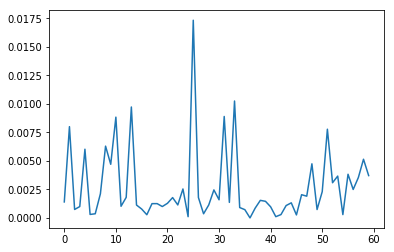

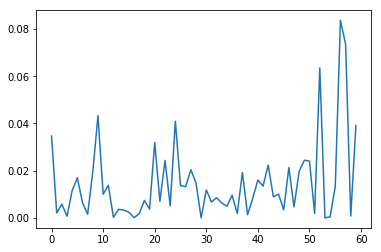

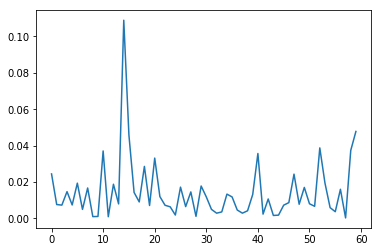

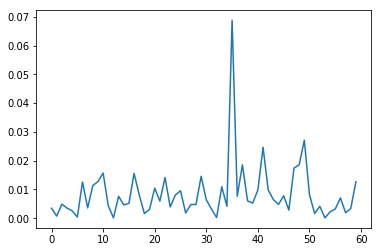

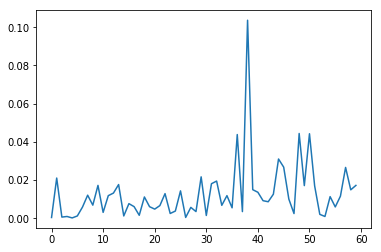

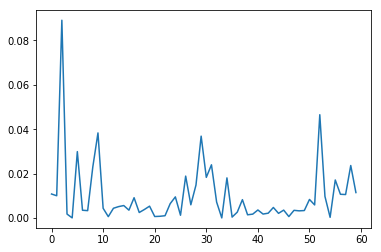

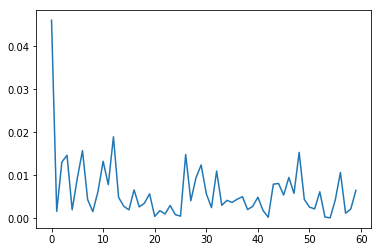

In [73]:
for idx in range(7):
    plt.plot(np.absolute(new_lr_coefs[0][0:60, idx]))
    plt.show()

In [74]:
print([key for key in new_flattened_landmarks_tr_pca])

['mouth', 'eyebrows', 'nose', 'eyes', 'jaw']


In [101]:
new_flattened_landmarks_tr_pca['eyebrows'].shape

(4721, 12)

In [105]:
lr_coef_neck[0].shape

(20, 2)

In [146]:
len([x for x in shape_model['cumulative_ratio'] if x < 0.99])

25

In [154]:
shape_model['cumulative_ratio'][22]

0.9876581957364337

In [40]:
with open('shape_model_normalised_mpie.pkl', 'rb') as lala:
    shape_model = pickle.load(lala, encoding='latin1')

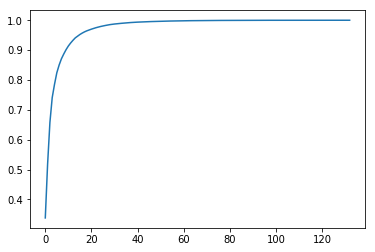

In [41]:
plt.plot(shape_model['var_acc_ratio'])

In [42]:
shape_model['components'].shape

(133, 136)

In [43]:
shape_model['mean'].dtype

dtype('float64')

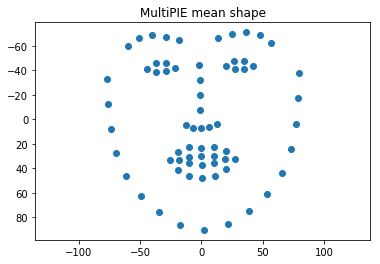

In [44]:
ax = plt.subplot(1, 1, 1)
plt.scatter(shape_model['mean'][:, 0], shape_model['mean'][:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('MultiPIE mean shape')
plt.show()

In [33]:
shape_model

{'components': array([[-0.10984488, -0.05329751, -0.11168302, ..., -0.09003003,
          0.02431754, -0.09374463],
        [ 0.12007786,  0.03202492,  0.11876597, ..., -0.04595671,
         -0.12838795, -0.0455769 ],
        [ 0.02058532,  0.12509342,  0.02089905, ...,  0.04743678,
         -0.08212247,  0.03778421],
        ...,
        [-0.02352463, -0.00135946,  0.01128539, ..., -0.00187526,
         -0.00938598,  0.00706062],
        [-0.0191339 , -0.00461196,  0.05493266, ...,  0.00823329,
         -0.00643711,  0.00208765],
        [-0.05256374, -0.02071819,  0.19249859, ...,  0.00846674,
         -0.02798679, -0.02019619]]),
 'mean': array([[-1.05657143e+02, -4.94601633e+01],
        [-1.04212143e+02, -2.18538300e+01],
        [-1.00294436e+02,  5.84836599e+00],
        [-9.44026903e+01,  3.31849822e+01],
        [-8.47347203e+01,  5.88488833e+01],
        [-6.92143803e+01,  8.14207398e+01],
        [-4.89817291e+01,  1.00064719e+02],
        [-2.51605464e+01,  1.13937678e+02],

In [213]:
neutral, _ = align_landmarks(valid_samples.iloc[0]['landmarks'], mean_shape, anchors)

In [220]:
magic = np.matmul(np.divide(neutral.flatten() - input_mean[0:136], input_std[0:136]), pca_basis[0:136, 0:dims995])

0.8104306589342305
0.15612573728176793


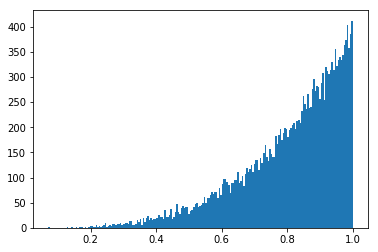

In [203]:
import math

lala = np.clip(np.random.uniform(0.0, 1.0, 20000), 0, 1)
gamma = math.log(0.85)/math.log(0.5)
lala2 = [x ** gamma for x in lala]
print(np.mean(lala2))
print(np.std(lala2))

plt.hist(lala2, 200)
plt.show()

In [13]:
# Create our custom sample set
default_actuator_values = [0.5] * 7
zeno_head = ZenoHead('127.0.0.1')
try:
    default_actuator_values = zeno_head.get_default_motor_positions()
finally:
    zeno_head.disconnect()
print('These are the default motor positions: ')
print(default_actuator_values)

These are the default motor positions: 
[0.5023696682464455, 0.7784090909090909, 0.5020408163265306, 0.8729508196721312, 0.5, 0.5017361111111112, 0.15753424657534246]


In [14]:
# Sample motor positions from skew distribution
motor_positions = np.random.uniform(0.0, 1.0, (len(training_examples), len(default_actuator_values)))
for idx in range(motor_positions.shape[0]):
    for dim in range(motor_positions.shape[1]):
        if default_actuator_values[dim] > 0.5:
            gamma = math.log(default_actuator_values[dim]) / math.log(0.5)
            motor_positions[idx, dim] = motor_positions[idx, dim] ** gamma
        else:
            gamma = math.log(1.0 - default_actuator_values[dim]) / math.log(0.5)
            motor_positions[idx, dim] = 1.0 - motor_positions[idx, dim] ** gamma

In [15]:
# Resample the training set
new_sampling_indices = []
old_training_motor_positions = [x['actuator_values'] for x in training_examples]
for position in motor_positions:
    new_sampling_indices.append(np.argmin([np.linalg.norm(position - x) for x in old_training_motor_positions]))

In [16]:
new_training_examples = [training_examples[x] for x in new_sampling_indices]
new_motor_positions = np.array([x['actuator_values'] for x in new_training_examples])

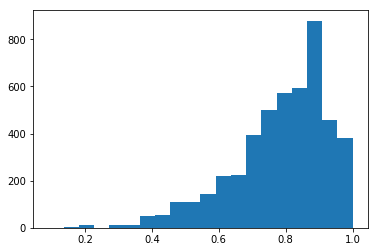

In [17]:
plt.hist(new_motor_positions[:, 3], 20)
plt.show()

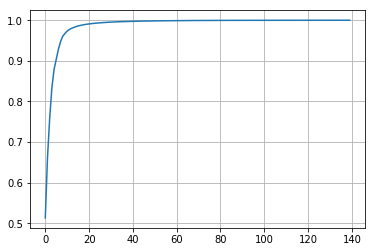

You need 30 dimensions to get 99.5% variation.


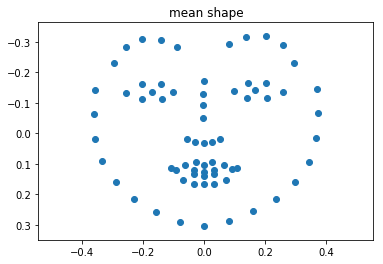

In [18]:
resampled_flattened_landmarks_tr, _, resampled_input_mean, resampled_input_std = prepare_training_set(new_training_examples)

eigen_values, eigen_vectors = np.linalg.eig(np.cov(resampled_flattened_landmarks_tr.T))
cumulative_eigen_values = [np.sum(eigen_values[0: x + 1]) / np.sum(eigen_values) 
                           for x in range(len(eigen_values))]
plt.plot(cumulative_eigen_values)
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.show()
resampled_dims995 = len([x for x in cumulative_eigen_values if x <= 0.995]) + 1
print('You need %d dimensions to get 99.5%% variation.' % resampled_dims995)
resampled_pca_basis = eigen_vectors
resampled_flattened_landmarks_tr_pca = np.matmul(resampled_flattened_landmarks_tr, pca_basis)

ax = plt.subplot(1, 1, 1)
plt.scatter(resampled_input_mean.reshape((-1, 2))[:, 0], resampled_input_mean.reshape((-1, 2))[:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('mean shape')
plt.show()

In [29]:
new_training_examples[0]

{'aam_eye_points': array([[529.6105 , 401.3164 ],
        [537.8874 , 400.9826 ],
        [551.6323 , 390.7138 ],
        [566.0727 , 398.39984],
        [553.24603, 410.555  ],
        [553.5515 , 398.72028],
        [586.19226, 400.3562 ],
        [654.84625, 396.78186],
        [657.6094 , 393.32925],
        [670.39545, 383.42578],
        [679.1511 , 389.42847],
        [670.49866, 398.67517],
        [667.50244, 390.68408],
        [698.8287 , 389.15942]], dtype=float32),
 'aam_fitting_scores': array([1.8803526, 1.5823966, 1.8506936], dtype=float32),
 'aam_head_pose': (-3.938828945159912, 32.69593048095703, -2.717388868331909),
 'aam_landmarks': array([[452.17127837, 392.70199344],
        [456.23463041, 424.77366676],
        [463.59953157, 456.14774637],
        [477.81553212, 484.60487185],
        [499.64905028, 509.03959121],
        [528.69152452, 528.03601309],
        [563.5826117 , 540.41363736],
        [599.15315799, 548.34829483],
        [632.04979277, 547.67582723],

In [5]:
sys.path.append('../iBUG1000')
from smile_detection_pipeline import extract_face_image


dataset_folder = os.path.realpath('./dataset2')
batch_folders = sorted(glob.glob(os.path.join(dataset_folder, 'batch_*')))
for batch_folder in batch_folders:
    print('Now processing: ' + batch_folder)
    face_folder = os.path.join(batch_folder, 'extracted_faces')
    if not os.path.exists(face_folder):
        os.makedirs(face_folder)
    data = pd.read_pickle(os.path.join(batch_folder, 'combined_samples.pkl'))
    for idx in range(data.shape[0]):
        image = cv2.imread(os.path.join(batch_folder, 'frame_%06d.png' % idx))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        face_image = extract_face_image(image, data.iloc[idx]['landmarks'], (300, 300), 
                                        (0.05, 0.1, 0.05, 0.1))[0]
        face_path = os.path.join(face_folder, 'frame_%06d.png' % idx)
        cv2.imwrite(face_path, face_image)
print('All done.')

Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_000
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_001
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_002
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_003
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_004
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_005
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_006
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_007
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_008
Now processing: D:\hhj\zeno_face_tracker\dataset2\batch_009
All done.


In [12]:
import os
import glob


dataset_folder = 'Z:/Databases/video/MultiPIE'
sessions = glob.glob(os.path.join(dataset_folder, 'Session*'))
for session in sessions:
    image_files = glob.glob(os.path.join(session, 'png/*'))
    print(len(image_files))

249
203
239
230


In [10]:
len(image_files)

0

In [8]:
print(image_files)

Z:/Databases/video/MultiPIE\png/*/*/*/*.png
